In [1]:
%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from nltools.file_reader import onsets_to_dm
from nltools.stats import regress, zscore
from nltools.data import Brain_Data, Design_Matrix
from nltools.stats import find_spikes 
from nltools.utils import concatenate
from nilearn.plotting import view_img, glass_brain, plot_stat_map


/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()


In [34]:
fmriprep_dir = '/mnt/c/Users/since/Desktop/KdramaSpring/data/derivatives/'
Data_dir = '/mnt/c/Users/since/Desktop/KdramaSpring/'
recall_dir = '/mnt/c/Users/since/Dropbox/Lab/Projects/CJY/Baldassano clips/_DATA'


In [3]:
def make_motion_covariates(mc, tr):
    z_mc = zscore(mc)
    all_mc = pd.concat([z_mc, z_mc**2, z_mc.diff(), z_mc.diff()**2], axis=1)
    all_mc.fillna(value=0, inplace=True) #결측값 변경 
    #print(all_mc)
    return Design_Matrix(all_mc, sampling_freq=1/tr)

# sub - 01

## Run1

In [7]:
sub = '01'
encoding_files = glob.glob(os.path.join(fmriprep_dir,f'sub-{sub}','func', '*encoding*smoothAROMAnonaggr_bold.nii.gz'))
encoding_files

['/mnt/c/Users/since/Desktop/KdramaSpring/data/derivatives/sub-01/func/sub-01_task-encoding_run-1_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz',
 '/mnt/c/Users/since/Desktop/KdramaSpring/data/derivatives/sub-01/func/sub-01_task-encoding_run-2_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz']

In [16]:
#load BOLD Volume 
func_imgs = {}
for run in np.arange(0,2):
    func_imgs[run] = nib.load(encoding_files[run]) 
print(func_imgs[0].shape)
print(func_imgs[1].shape)
func_imgs[0].shape[3]

(91, 109, 91, 604)
(91, 109, 91, 600)


604

In [25]:
#Run1
n_trs = [func_imgs[0].shape[3], func_imgs[1].shape[3]] 
n_tr = n_trs[0]
print(n_tr)

#YesStimulus = np.zeros(n_tr)
countdown = np.zeros(n_tr)
YesStimulus = np.zeros(n_tr)
story1 = np.zeros(n_tr)
story2 = np.zeros(n_tr)
story3 = np.zeros(n_tr)
story4 = np.zeros(n_tr)
story5 = np.zeros(n_tr)

# for k in np.range(0,4):
countdown[0:10] =1 
YesStimulus[11:120] = 1
story1[11:120] = 1

countdown[121:130] =1
YesStimulus[131:240] = 1
story2[131:240] = 1

countdown[241:250] =1 
YesStimulus[251:360] = 1
story3[251:360] = 1

countdown[361:370] =1 
YesStimulus[371:480] = 1
story4[371:480] = 1

countdown[481:490] =1 
YesStimulus[491:600] = 1
story5[491:600] = 1

countdown.shape

604


(604,)

In [28]:
from nltools.data import Brain_Data, Design_Matrix
TR = 1
intercept = np.ones(n_tr)
x1 = (np.vstack([[countdown], [YesStimulus], [story1], [story2], [story3], [story4], [story5]])).T
print(x1.shape)
dm1 = Design_Matrix(x1, sampling_freq = 1./TR, columns = ['countdown', 'YesStimulus', 'story1', 'story2', 'story3', 'story4', 'story5'])

(604, 7)


In [23]:
def plot_timeseries(data, labels=None, linewidth=3):
    '''Plot a timeseries
    
    Args:
        data: (np.ndarray) signal varying over time, where each column is a different signal.
        labels: (list) labels which need to correspond to the number of columns.
        linewidth: (int) thickness of line
    '''
    plt.figure(figsize=(20,5))
    plt.plot(data, linewidth=linewidth)
    plt.ylabel('Intensity', fontsize=18)
    plt.xlabel('Time', fontsize=18)
    plt.tight_layout()
    if labels is not None:
        if len(labels) != data.shape[1]:
            raise ValueError('Need to have the same number of labels as columns in data.')
        plt.legend(labels, fontsize=18)

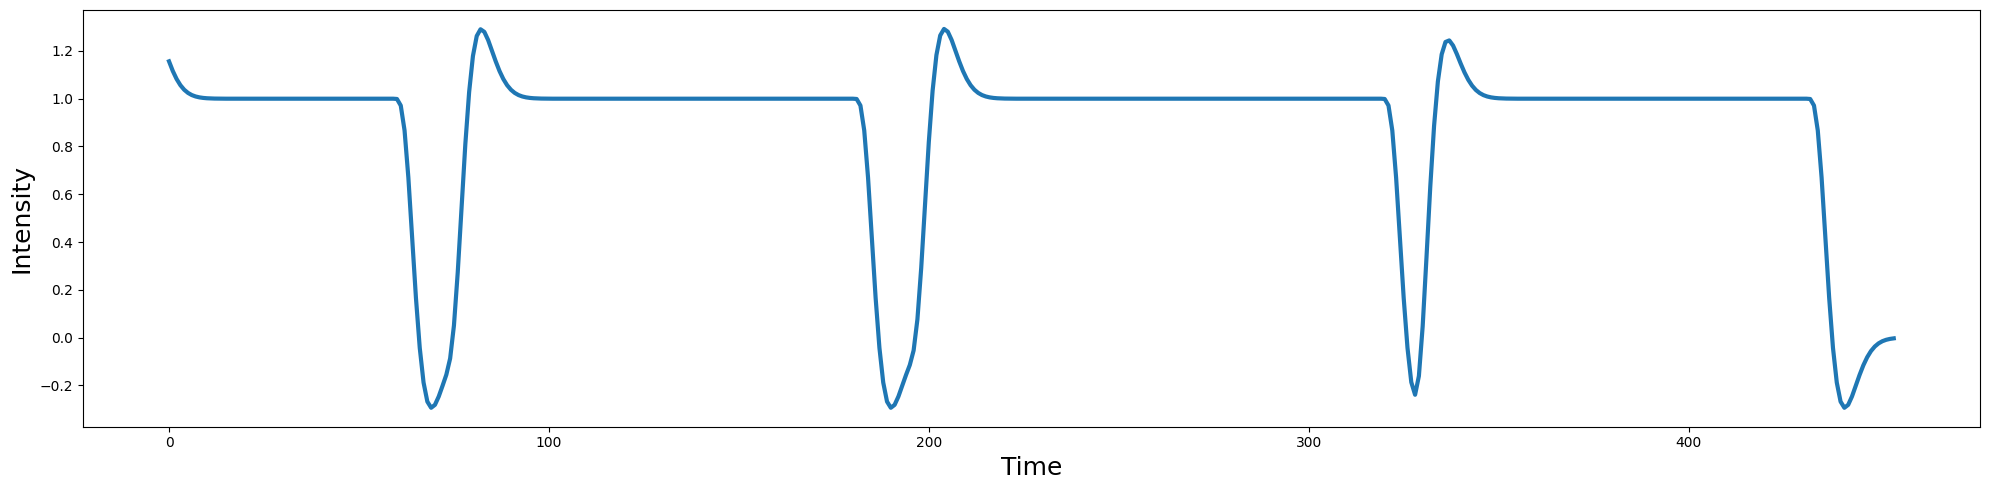

In [15]:
speak_conv = np.convolve(speak, hrf, mode='same')
voxel_conv = speak_conv.T
plot_timeseries(voxel_conv)

(455,)
(455,)


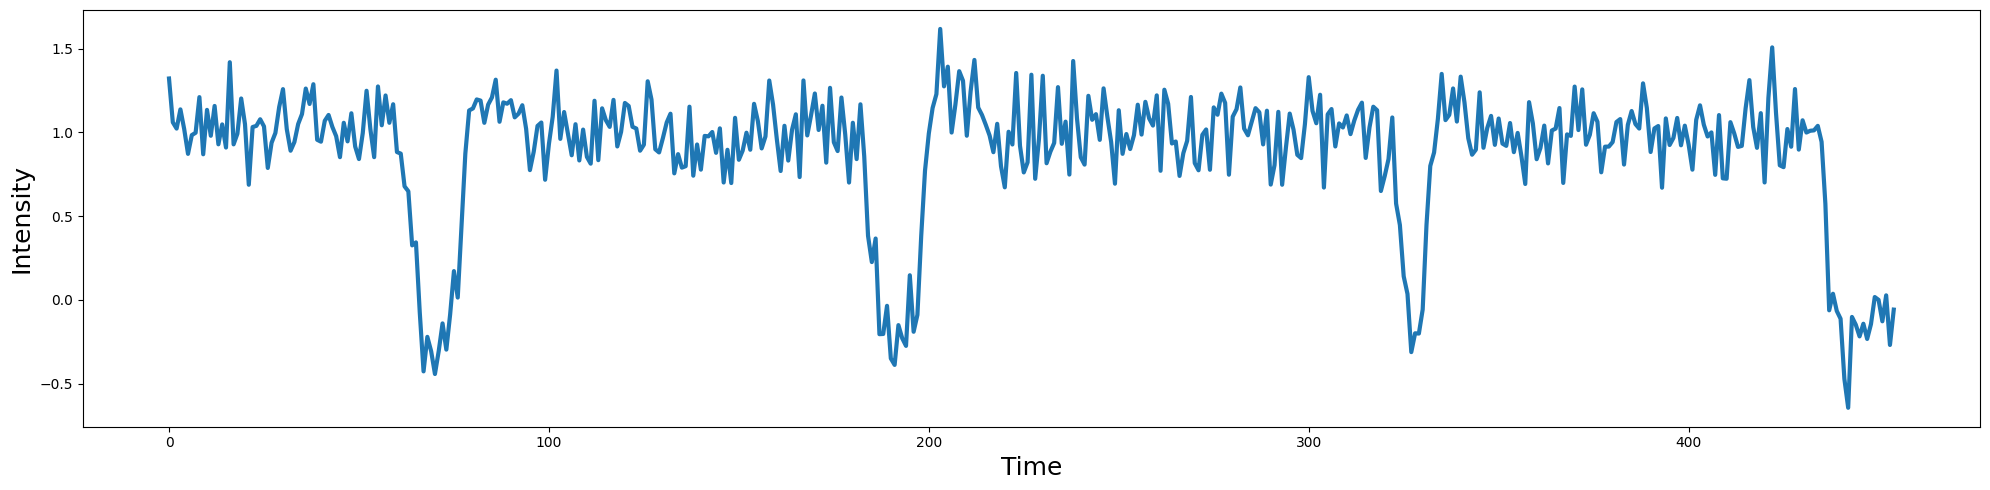

In [16]:
sigma = 0.15
epsilon = sigma*np.random.randn(n_tr)
print(epsilon.shape)
print(voxel_conv.shape)
voxel_conv_noise = voxel_conv + epsilon

plot_timeseries(voxel_conv_noise)

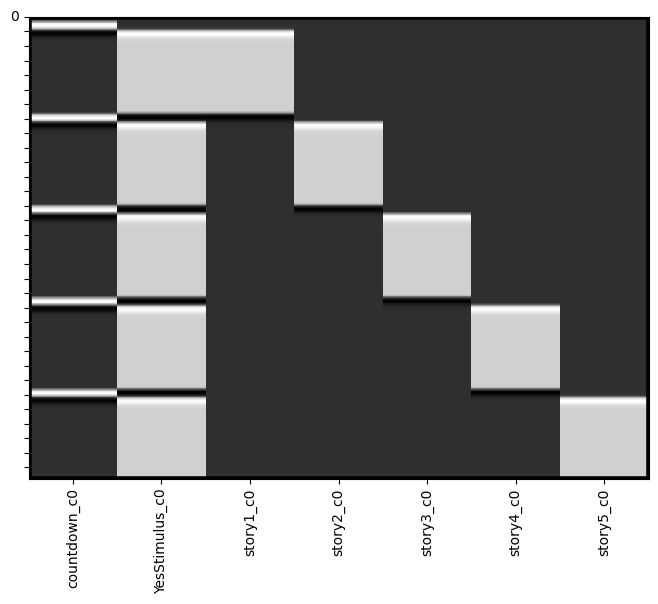

In [29]:
dm_conv1 = dm1.convolve()
dm_conv1.heatmap()

<AxesSubplot:>

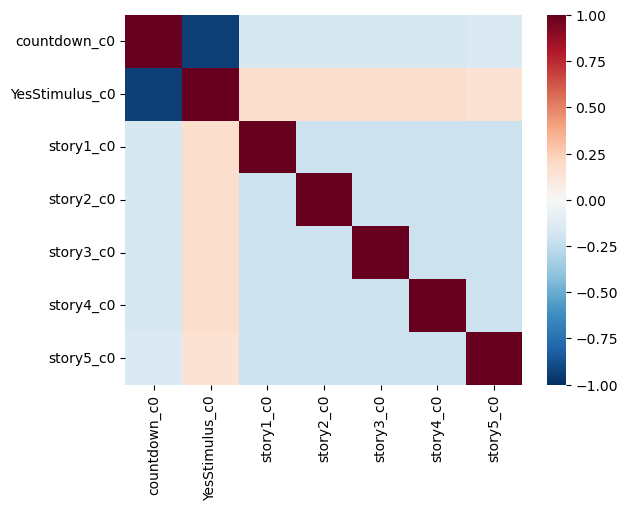

In [32]:
sns.heatmap(dm_conv1.corr(), vmin=-1, vmax=1, cmap='RdBu_r')

Text(0, 0.5, 'Variance Inflation Factor')

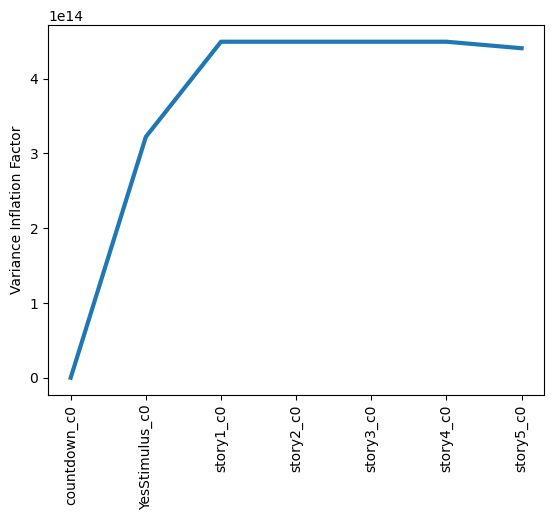

In [33]:
plt.plot(dm_conv1.columns, dm_conv1.vif(), linewidth=3)
plt.xticks(rotation=90)
plt.ylabel('Variance Inflation Factor')

In [34]:
dm_conv_filt1 = dm_conv1.add_dct_basis(duration=128)

<AxesSubplot:>

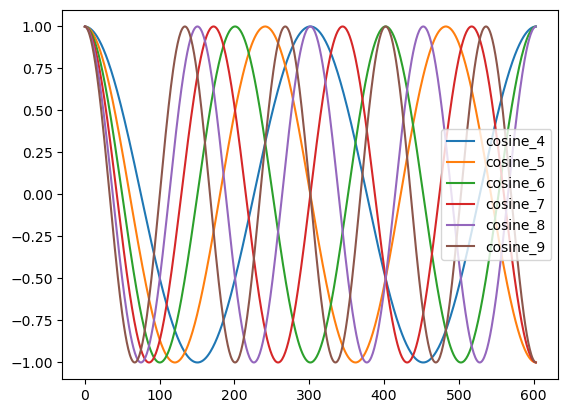

In [35]:
dm_conv_filt1.iloc[:,10:].plot()

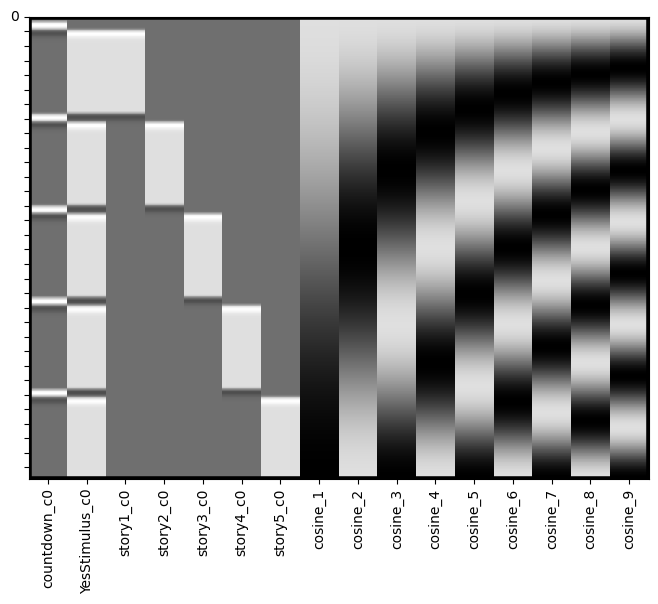

In [36]:
dm_conv_filt1 = dm_conv1.add_dct_basis(duration=128)
dm_conv_filt1.heatmap()

Design Matrix already has 0th order polynomial...skipping


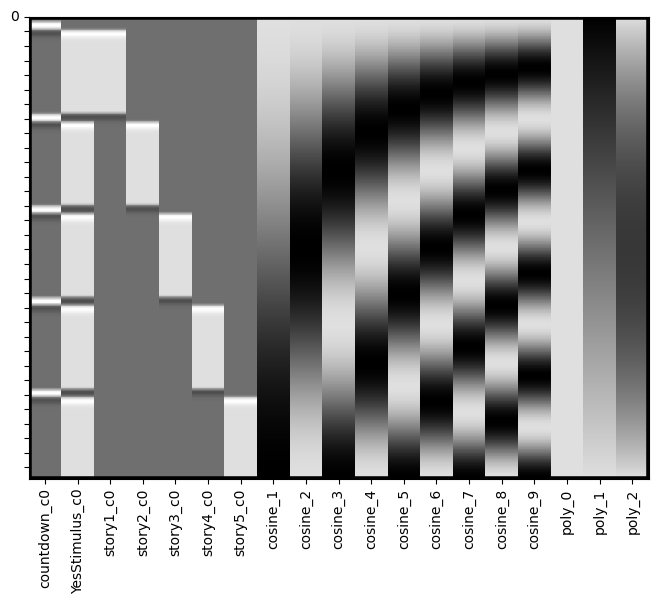

In [37]:
dm_conv_filt_poly1 = dm_conv_filt1.add_poly()
dm_conv_filt_poly1 = dm_conv_filt_poly1.add_poly(order=2, include_lower=True)
dm_conv_filt_poly1.heatmap()

In [39]:
base_dir = '/mnt/c/Users/since/Desktop/KdramaSpring/data/derivatives/'
tr = 1.5
outlier_cutoff = 3 # outlier threashold
sub = 'sub-01'
task = 'task-encoding'
run = 'run-1'

data1= Brain_Data(encoding_files[0])
spikes = data1.find_spikes(global_spike_cutoff=outlier_cutoff, diff_spike_cutoff=outlier_cutoff) # global signal outlier
covariates = pd.read_csv(glob.glob(os.path.join(base_dir, sub, 'func', f'*{sub}_{task}_{run}_desc-confounds_timeseries.tsv'))[0], sep='\t')
motionOutliers = covariates.filter(regex='motion_outlier')
mc = covariates[['trans_x','trans_y','trans_z','rot_x', 'rot_y', 'rot_z']]
mc_cov = make_motion_covariates(mc, tr) #motion parameter

<AxesSubplot:>

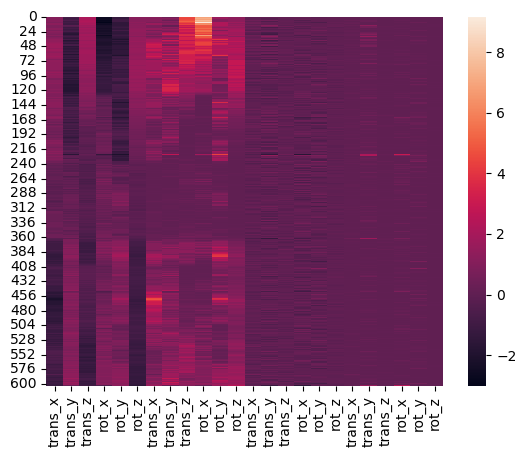

In [40]:
sns.heatmap(mc_cov)

Text(0, 0.5, 'Intensity')

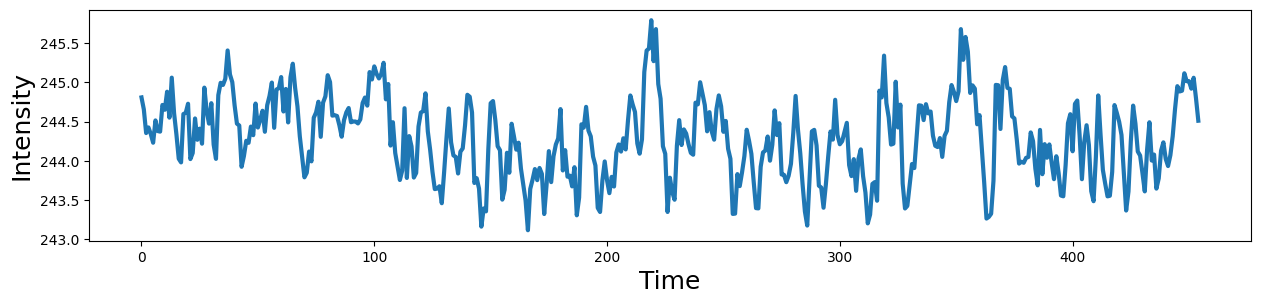

In [74]:
plt.figure(figsize=(15,3))
plt.plot(np.mean(data.data, axis=1), linewidth=3)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Intensity', fontsize=18)

<AxesSubplot:>

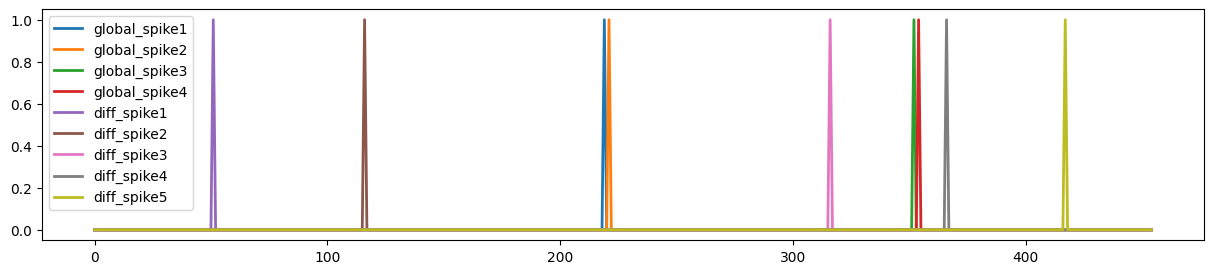

In [75]:
spikes = data.find_spikes(global_spike_cutoff=2.5, diff_spike_cutoff=2.5)

f, a = plt.subplots(figsize=(15,3))
spikes = Design_Matrix(spikes.iloc[:,1:], sampling_freq=1/tr)
spikes.plot(ax = a, linewidth=2)

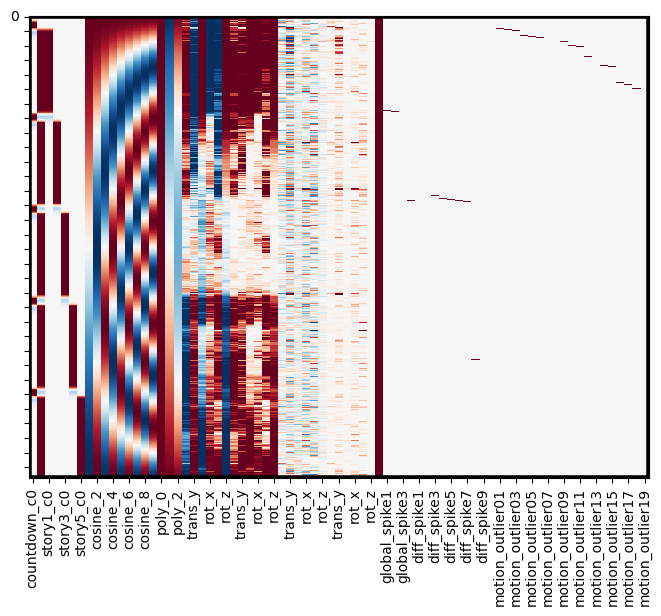

In [41]:
dm_conv_filt_poly_cov1 = pd.concat([dm_conv_filt_poly1, mc_cov, spikes, motionOutliers], axis=1)
dm_conv_filt_poly_cov1.heatmap(cmap='RdBu_r', vmin=-1,vmax=1)

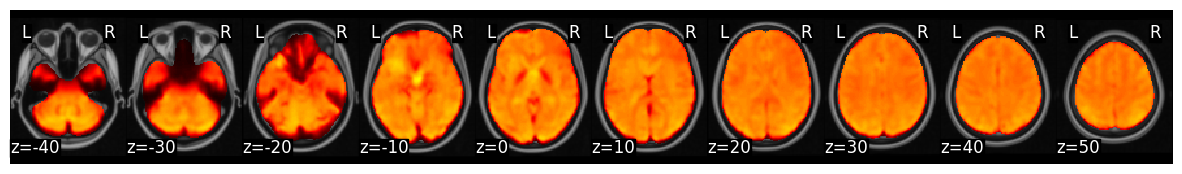

In [36]:
data1.mean().plot() # 지금보고있는건 AROMA 여서 할 필요없음.

In [42]:
data1.X= dm_conv_filt_poly_cov1
stats1 = data1.regress()

In [44]:
print(data1.X.columns)

Index(['countdown_c0', 'YesStimulus_c0', 'story1_c0', 'story2_c0', 'story3_c0',
       'story4_c0', 'story5_c0', 'cosine_1', 'cosine_2', 'cosine_3',
       'cosine_4', 'cosine_5', 'cosine_6', 'cosine_7', 'cosine_8', 'cosine_9',
       'poly_0', 'poly_1', 'poly_2', 'trans_x', 'trans_y', 'trans_z', 'rot_x',
       'rot_y', 'rot_z', 'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y',
       'rot_z', 'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z',
       'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'TR',
       'global_spike1', 'global_spike2', 'global_spike3', 'global_spike4',
       'diff_spike1', 'diff_spike2', 'diff_spike3', 'diff_spike4',
       'diff_spike5', 'diff_spike6', 'diff_spike7', 'diff_spike8',
       'diff_spike9', 'motion_outlier00', 'motion_outlier01',
       'motion_outlier02', 'motion_outlier03', 'motion_outlier04',
       'motion_outlier05', 'motion_outlier06', 'motion_outlier07',
       'motion_outlier08', 'motion_outlier09', 'motion_outlier1

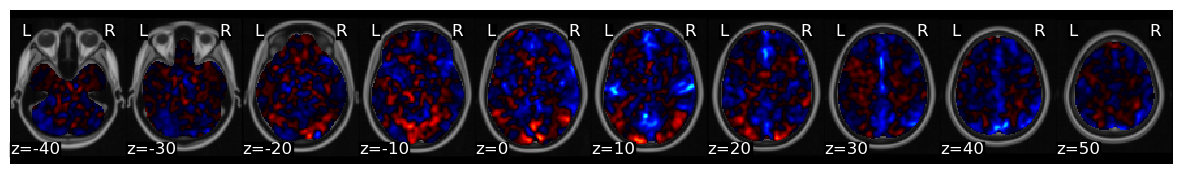

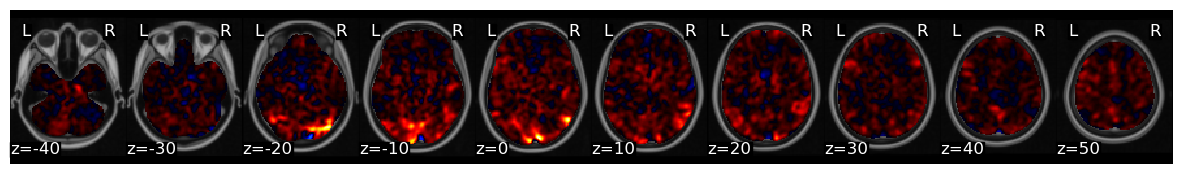

In [48]:
stats1['beta'][1].plot()
cont = stats1['beta'][1] - stats1['beta'][0]
cont.plot()

In [18]:
cd /mnt/c/Users/since/Desktop/

/mnt/c/Users/since/Desktop


In [19]:
stats1['beta'].write(f'{sub}_run-1_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz')
#stats1['beta'][2].write(f'{sub}_run-2_nonspeak_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz')

# For 4 subjects

In [4]:
subjects = ['01', '02', '03','04']
encoding_files = {}
func_imgs = {}
n_trs = {}
for sub in subjects:
    encoding_files[sub] = glob.glob(os.path.join(fmriprep_dir,f'sub-{sub}','func', '*encoding*smoothAROMAnonaggr_bold.nii.gz'))    
    func_img = {}
    n_tr = {}
    for run in np.arange(0,2):
        func_img[run] = nib.load(encoding_files[sub][run])
        n_tr[run] = func_img[run].shape[3]
    func_imgs[sub] = func_img
    n_trs[sub] = n_tr 
func_imgs
n_trs['01'][0]

604

In [118]:
nib.load(encoding_files['01'][1]).shape

(91, 109, 91, 600)

start 01
604
finish to make a timepoints
Design Matrix already has 0th order polynomial...skipping
finish to make a DM
finish to add CVs
600
finish to make a timepoints
Design Matrix already has 0th order polynomial...skipping
finish to make a DM
finish to add CVs
start 02
604
finish to make a timepoints
Design Matrix already has 0th order polynomial...skipping
finish to make a DM
finish to add CVs
604
finish to make a timepoints
Design Matrix already has 0th order polynomial...skipping
finish to make a DM
finish to add CVs
start 03
604
finish to make a timepoints
Design Matrix already has 0th order polynomial...skipping
finish to make a DM
finish to add CVs
604
finish to make a timepoints
Design Matrix already has 0th order polynomial...skipping
finish to make a DM
finish to add CVs
start 04
604
finish to make a timepoints
Design Matrix already has 0th order polynomial...skipping
finish to make a DM
finish to add CVs
604
finish to make a timepoints
Design Matrix already has 0th order 

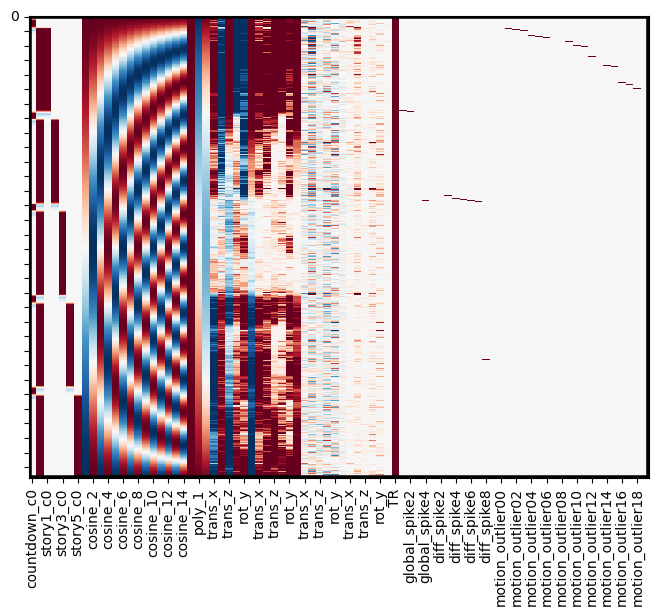

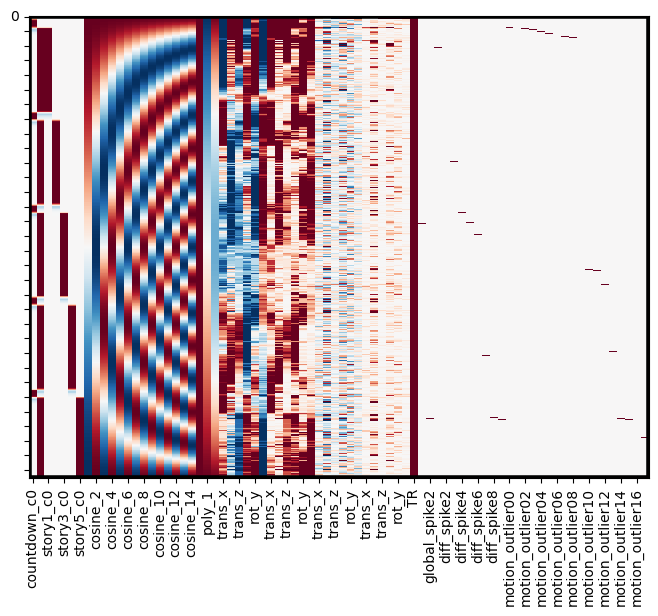

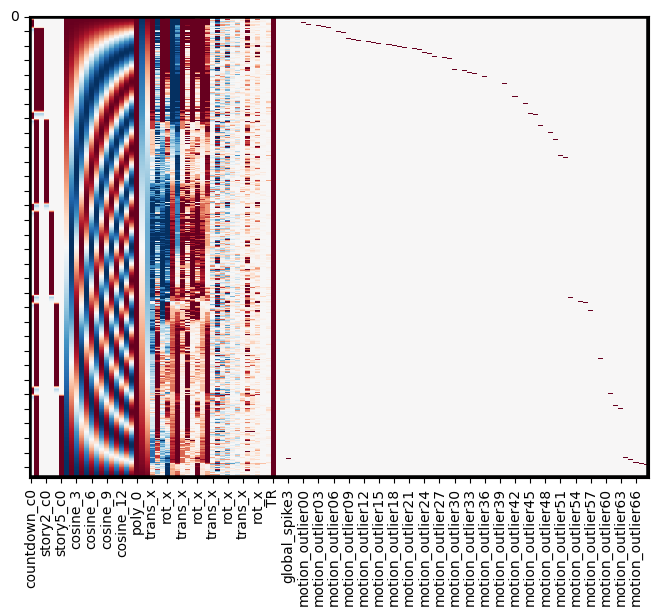

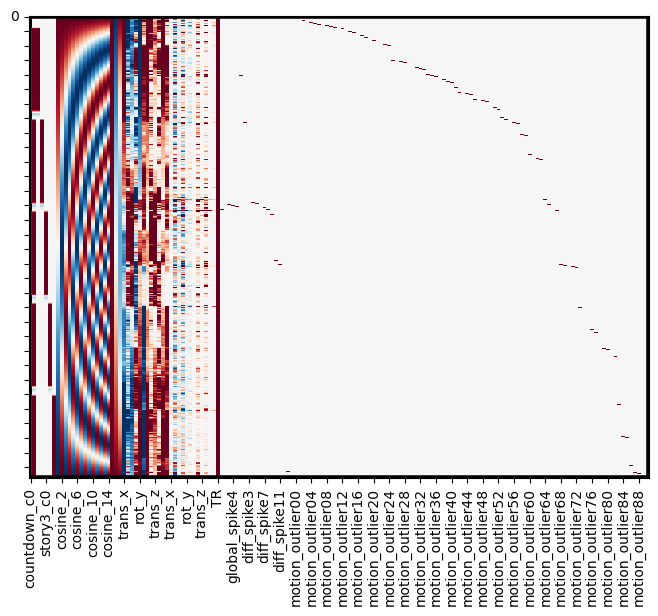

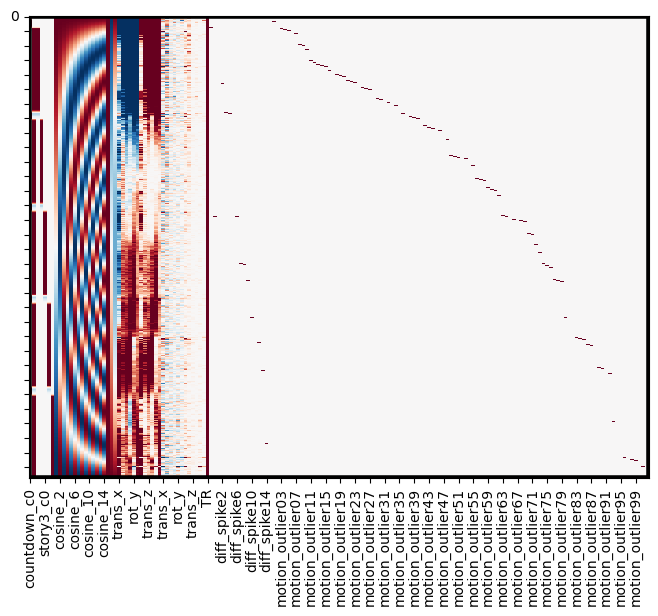

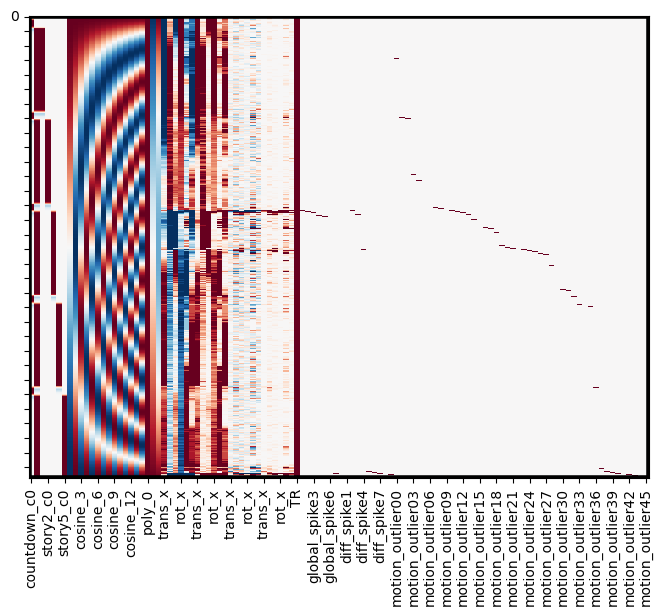

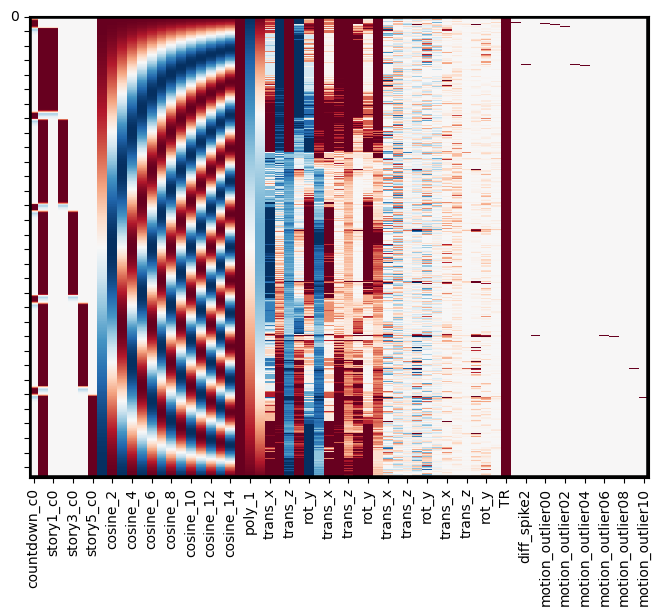

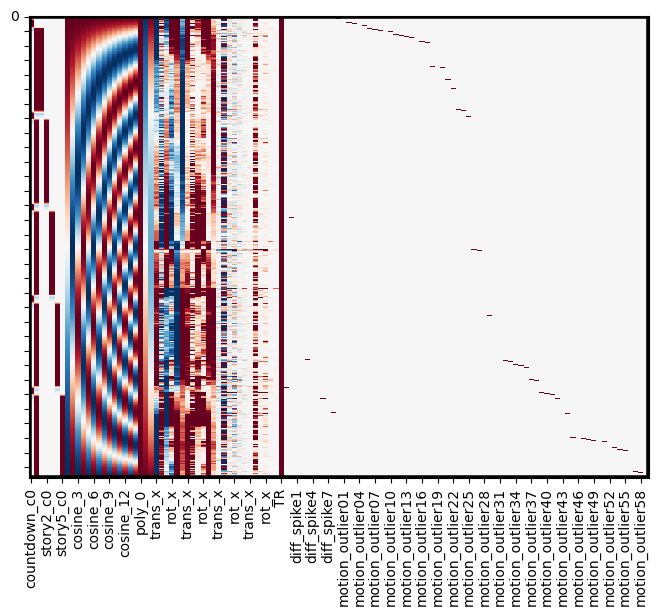

In [5]:
TR = 1.5
outlier_cutoff = 3
conts = {}
for sub in subjects:
    print(f'start {sub}')
    cont = {}
    for run in np.arange(0,2):
        tr = n_trs[sub][run]
        print(tr)
    
        #YesStimulus = np.zeros(n_tr)
        countdown = np.zeros(tr)
        YesStimulus = np.zeros(tr)
        story1 = np.zeros(tr)
        story2 = np.zeros(tr)
        story3 = np.zeros(tr)
        story4 = np.zeros(tr)
        story5 = np.zeros(tr)

        # for k in np.range(0,4):
        countdown[0:10] =1 
        YesStimulus[11:120] = 1
        story1[11:120] = 1

        countdown[121:130] =1
        YesStimulus[131:240] = 1
        story2[131:240] = 1

        countdown[241:250] =1 
        YesStimulus[251:360] = 1
        story3[251:360] = 1

        countdown[361:370] =1 
        YesStimulus[371:480] = 1
        story4[371:480] = 1

        countdown[481:490] =1 
        YesStimulus[491:600] = 1
        story5[491:600] = 1
        print('finish to make a timepoints')
        
        x = (np.vstack([[countdown], [YesStimulus], [story1], [story2], [story3], [story4], [story5]])).T
        dm = Design_Matrix(x, sampling_freq = 1./TR, columns = ['countdown', 'YesStimulus', 'story1', 'story2', 'story3', 'story4', 'story5'])
        dm_conv = dm.convolve()
        dm_conv_filt = dm_conv.add_dct_basis(duration=128)
        dm_conv_filt_poly = dm_conv_filt.add_poly()
        dm_conv_filt_poly = dm_conv_filt_poly.add_poly(order=2, include_lower=True)
        print(f'finish to make a DM') 
        
        #motion correction
        data= Brain_Data(encoding_files[sub][run])
        spikes = data.find_spikes(global_spike_cutoff=outlier_cutoff, diff_spike_cutoff=outlier_cutoff) # global signal outlier
        covariates = pd.read_csv(glob.glob(os.path.join(fmriprep_dir, f'sub-{sub}', 'func', f'sub-{sub}_task-encoding_run-{run+1}_desc-confounds_timeseries.tsv'))[0], sep='\t')
        motionOutliers = covariates.filter(regex='motion_outlier')
        mc = covariates[['trans_x','trans_y','trans_z','rot_x', 'rot_y', 'rot_z']]
        mc_cov = make_motion_covariates(mc, TR) #motion parameter
        
        dm_conv_filt_poly_cov = pd.concat([dm_conv_filt_poly, mc_cov, spikes, motionOutliers], axis=1)
        print(f'finish to add CVs')
        dm_conv_filt_poly_cov.heatmap(cmap='RdBu_r', vmin=-1,vmax=1)
        
        data.X= dm_conv_filt_poly_cov
        stats = data.regress()
        temp = stats['beta'][1] - stats['beta'][0]
        cont[run] = temp
        stats['beta'][1].write(os.path.join(fmriprep_dir,'betas', f'sub-{sub}_task-encoding_stimulus_run-{run+1}_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz'))
        stats['beta'][0].write(os.path.join(fmriprep_dir,'betas', f'sub-{sub}_task-encoding_fixation_run-{run+1}_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz'))
        temp.write(os.path.join(fmriprep_dir,'betas', f'sub-{sub}_task-encoding_stimulus_contrast_run-{run+1}_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz'))
    conts[sub] = cont


In [211]:
#Load beta data 
beta_files = glob.glob(os.path.join(fmriprep_dir,'betas', '*_task-encoding_stimulus_contrast_run-*_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz'))
beta_files

#Runlevel anaysis for compare across the conditions 
sub1 = Brain_Data(glob.glob(os.path.join(fmriprep_dir,'betas', 'sub-01_task-encoding_stimulus_contrast_run-*_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz'))).mean()
sub2 = Brain_Data(glob.glob(os.path.join(fmriprep_dir,'betas', 'sub-02_task-encoding_stimulus_contrast_run-*_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz'))).mean()
sub3 = Brain_Data(glob.glob(os.path.join(fmriprep_dir,'betas', 'sub-03_task-encoding_stimulus_contrast_run-*_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz'))).mean()
sub4 = Brain_Data(glob.glob(os.path.join(fmriprep_dir,'betas', 'sub-04_task-encoding_stimulus_contrast_run-*_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz'))).mean()

sub1.write(os.path.join(fmriprep_dir,'betas', 'sub-01_task-encoding_stimulus_contrast_average_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz'))
sub2.write(os.path.join(fmriprep_dir,'betas', 'sub-02_task-encoding_stimulus_contrast_average_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz'))
sub3.write(os.path.join(fmriprep_dir,'betas', 'sub-03_task-encoding_stimulus_contrast_average_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz'))
sub4.write(os.path.join(fmriprep_dir,'betas', 'sub-04_task-encoding_stimulus_contrast_average_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz'))

#load beta datas for each condition : compare stimulus 'on' vs 'off' 
subs_visual = Brain_Data(glob.glob(os.path.join(fmriprep_dir,'betas', 'sub-*_task-encoding_stimulus_contrast_run-1_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz')))
subs_Audio = Brain_Data(glob.glob(os.path.join(fmriprep_dir,'betas', 'sub-*_task-encoding_stimulus_contrast_run-2_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz')))

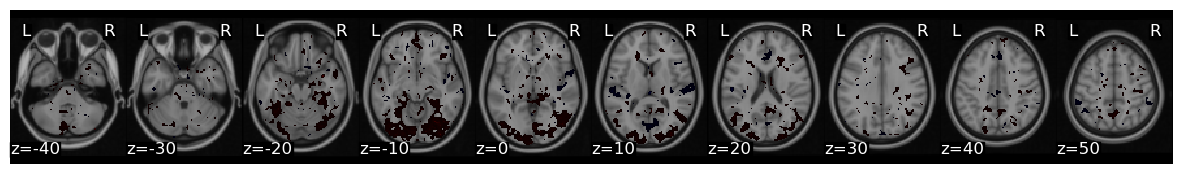

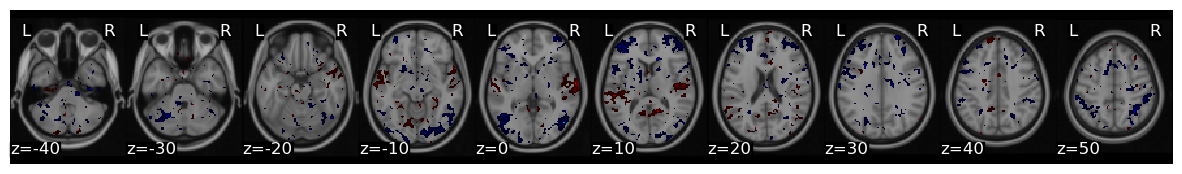

In [213]:
#Group level analysis 
visual_stats = subs_visual.ttest(threshold_dict={'unc':.05} )
visual_stats['thr_t'].plot()
visual_stats['thr_t'].write(os.path.join(fmriprep_dir,'betas', 'subjects_Visual_task-encoding_stimulus_contrast_average_ttest_unc_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz'))

Audio_stats = subs_Audio.ttest(threshold_dict={'unc':.05} )
Audio_stats['thr_t'].plot()
Audio_stats['thr_t'].write(os.path.join(fmriprep_dir,'betas', 'subjects_Audio_task-encoding_stimulus_contrast_average_ttest_unc_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz'))

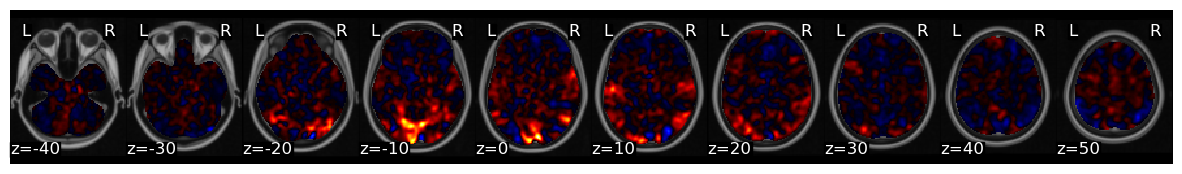

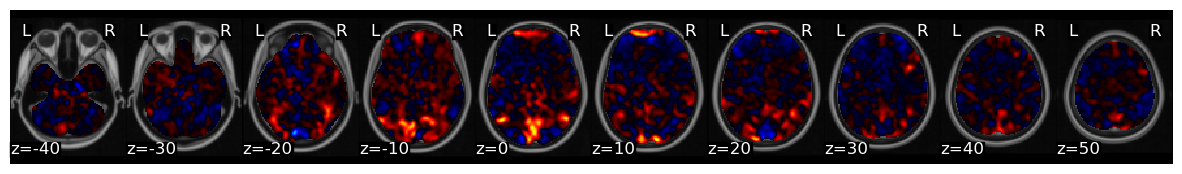

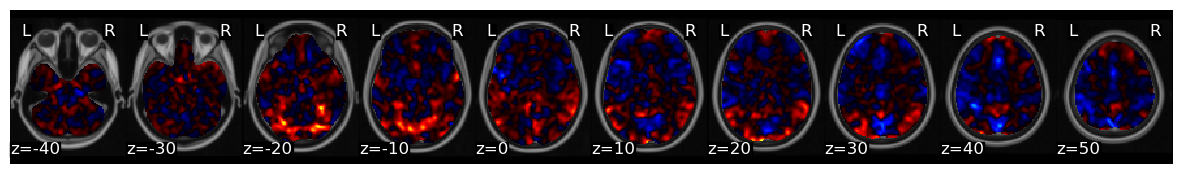

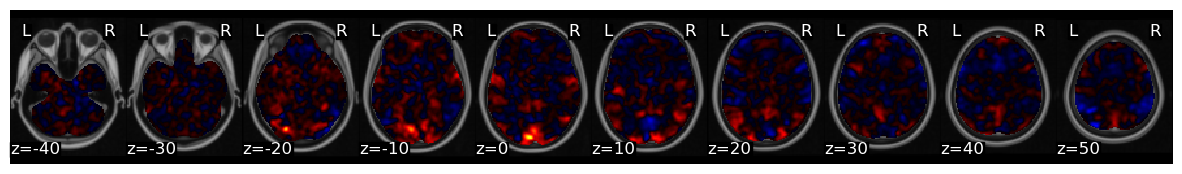

In [186]:
sub1.plot()
sub2.plot()
sub3.plot()
sub4.plot()

# Recall data GLM

In [8]:
#load matlab files 
import scipy.io as sio  # mat load
import math # 올림 

## sub-01 recall

In [82]:
sub = '01'
run = 0
fileName = glob.glob(os.path.join(Data_dir, 'recalls', f'sub-01_task-recall_countered-*_stimulusCond-0{run+1}*.mat'))[0]
mat = sio.loadmat(fileName)
mat['data'][0][0][10] #recall_startTime - 
print(mat['data'][0][0][10].shape)
mat['data'][0][0][11]/1.5
# mat
#os.path.join(recall_dir, f'sub-{sub}_task-recall_*_stimulusCond-0{run+1}.mat')

(4, 1)


array([[110.60312213],
       [ 98.9199742 ],
       [152.7827142 ],
       [114.25367427]])

In [127]:
 glob.glob(os.path.join(fmriprep_dir,f'sub-{sub}','func', f'sub-{sub}_task-recall_run-{run+1}_*smoothAROMAnonaggr_bold.nii.gz'))

['/mnt/c/Users/since/Desktop/KdramaSpring/data/derivatives/sub-04/func/sub-04_task-recall_run-2_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz']

In [107]:
recall_files = glob.glob(os.path.join(fmriprep_dir,f'sub-{sub}','func', '*recall*smoothAROMAnonaggr_bold.nii.gz'))[0]
n_tr = nib.load(recall_files).shape[3]
print(111 + 99 + 153 + 115 + 10*3 + 5)
speak_timepoint = [1, 1+111, 1+111+10, 1+111+10+99, 1+111+10+99+10,  1+111+10+99+10+153,  1+111+10+99+10+153+10,  1+111+10+99+10+153+10+115]
print(speak_timepoint)

speak = np.zeros(n_tr)
nonspeak = np.zeros(n_tr)
story1 = np.zeros(n_tr)
story2 = np.zeros(n_tr)
story3 = np.zeros(n_tr)
story4 = np.zeros(n_tr)

nonspeak[0:1]=1

speak[speak_timepoint[0]:speak_timepoint[1]] = 1
story1[speak_timepoint[0]:speak_timepoint[1]] = 1
nonspeak[speak_timepoint[1]+1:speak_timepoint[2]-1]=1

speak[speak_timepoint[2]:speak_timepoint[3]] = 1
story2[speak_timepoint[2]:speak_timepoint[3]] = 1
nonspeak[speak_timepoint[3]+1:speak_timepoint[4]-1]=1

speak[speak_timepoint[4]:speak_timepoint[5]] = 1
story3[speak_timepoint[4]:speak_timepoint[5]] = 1
nonspeak[speak_timepoint[5]+1:speak_timepoint[6]-1]=1

speak[speak_timepoint[6]:speak_timepoint[7]] = 1
story4[speak_timepoint[6]:speak_timepoint[7]] = 1
nonspeak[speak_timepoint[7]+1:]=1
nonspeak

TR = 1.5
intercept = np.ones(n_tr)
x = (np.vstack([[nonspeak], [speak], [story1], [story2], [story3], [story4]])).T
dm = Design_Matrix(x, sampling_freq = 1./TR, columns = ['nonspeak','speak', 'story1', 'story2', 'story3', 'story4'])
dm_conv = dm.convolve()
dm_conv_filt = dm_conv.add_dct_basis(duration=128)
dm_conv_filt_poly = dm_conv_filt.add_poly()
dm_conv_filt_poly = dm_conv_filt_poly.add_poly(order=2, include_lower=True)

513
[1, 112, 122, 221, 231, 384, 394, 509]
Design Matrix already has 0th order polynomial...skipping


In [119]:
#CV
outlier_cutoff = 3 # outlier threashold
data = Brain_Data(recall_files)
spikes = data.find_spikes(global_spike_cutoff=outlier_cutoff, diff_spike_cutoff=outlier_cutoff) # global signal outlier
covariates = pd.read_csv(glob.glob(os.path.join(fmriprep_dir, f'sub-{sub}', 'func', f'sub-{sub}_task-recall_run-{run+1}_desc-confounds_timeseries.tsv'))[0], sep='\t')
motionOutliers = covariates.filter(regex='motion_outlier')
mc = covariates[['trans_x','trans_y','trans_z','rot_x', 'rot_y', 'rot_z']]
mc_cov = make_motion_covariates(mc, TR) #motion parameter

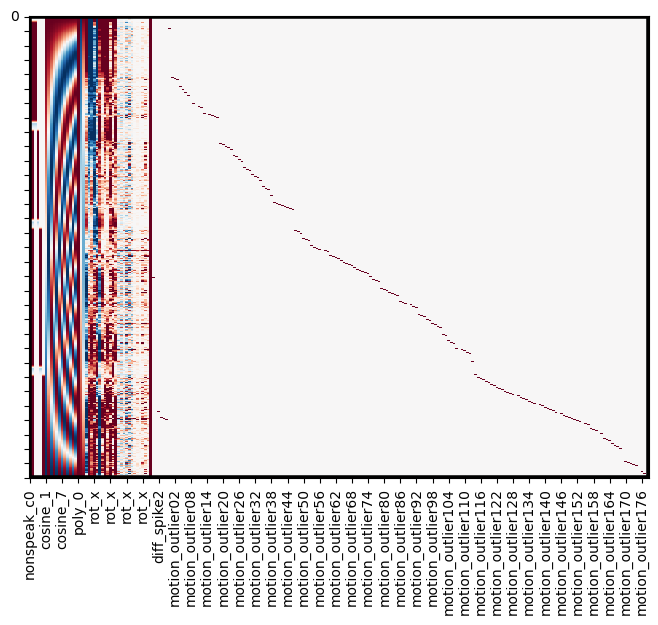

In [120]:
dm_conv_filt_poly_cov = pd.concat([dm_conv_filt_poly, mc_cov, spikes, motionOutliers], axis=1)
dm_conv_filt_poly_cov.heatmap(cmap='RdBu_r', vmin=-1,vmax=1)

In [121]:
data.X= dm_conv_filt_poly_cov
stats = data.regress()

nltools.data.brain_data.Brain_Data(data=(231, 238955), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz)

In [122]:
print(data.X.columns)

Index(['nonspeak_c0', 'speak_c0', 'story1_c0', 'story2_c0', 'story3_c0',
       'story4_c0', 'cosine_1', 'cosine_2', 'cosine_3', 'cosine_4',
       ...
       'motion_outlier169', 'motion_outlier170', 'motion_outlier171',
       'motion_outlier172', 'motion_outlier173', 'motion_outlier174',
       'motion_outlier175', 'motion_outlier176', 'motion_outlier177',
       'motion_outlier178'],
      dtype='object', length=231)


{'beta': nltools.data.brain_data.Brain_Data(data=(231, 238955), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz), 't': nltools.data.brain_data.Brain_Data(data=(231, 238955), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz), 'p': nltools.data.brain_data.Brain_Data(data=(231, 238955), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz), 'df': nltools.data.brain_data.Brain_Data(data=(238955,), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz), 'sigma': nltools.data.brain_data.Brain_Data(data=(231, 238955), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz), 'residual': nltools.data.brain_data.Brain_Data(data=(513, 238955), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz)}


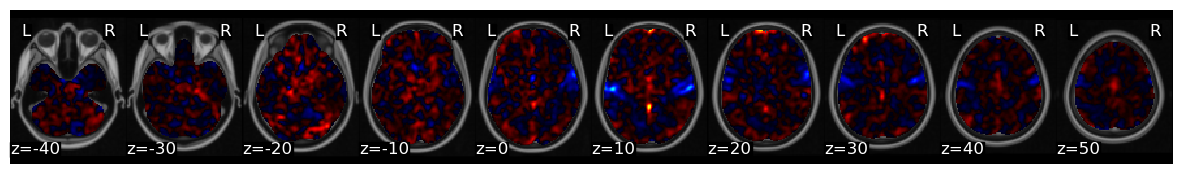

In [124]:
print(stats)
cont= stats['beta'][0] - stats['beta'][1]
cont.plot()

## 4 subjects recall

Design Matrix already has 0th order polynomial...skipping
Design Matrix already has 0th order polynomial...skipping
Design Matrix already has 0th order polynomial...skipping
Design Matrix already has 0th order polynomial...skipping
Design Matrix already has 0th order polynomial...skipping
Design Matrix already has 0th order polynomial...skipping
Design Matrix already has 0th order polynomial...skipping
Design Matrix already has 0th order polynomial...skipping


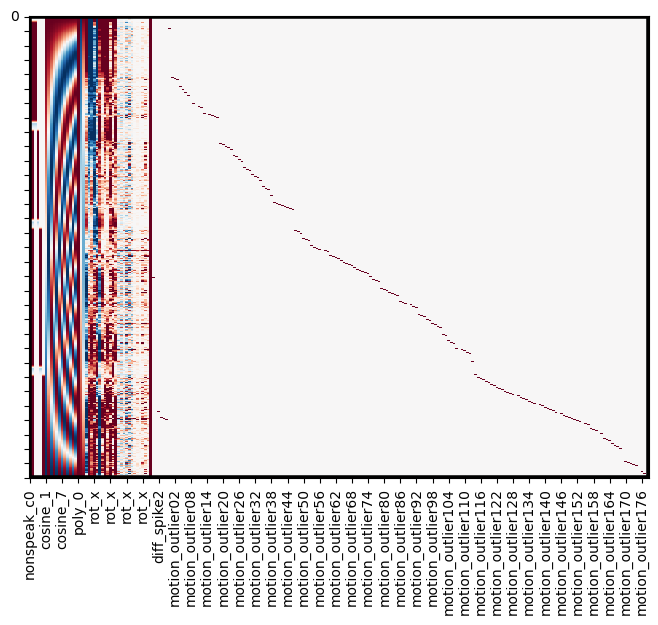

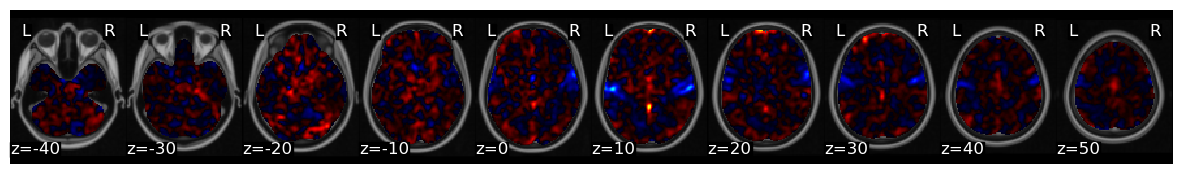

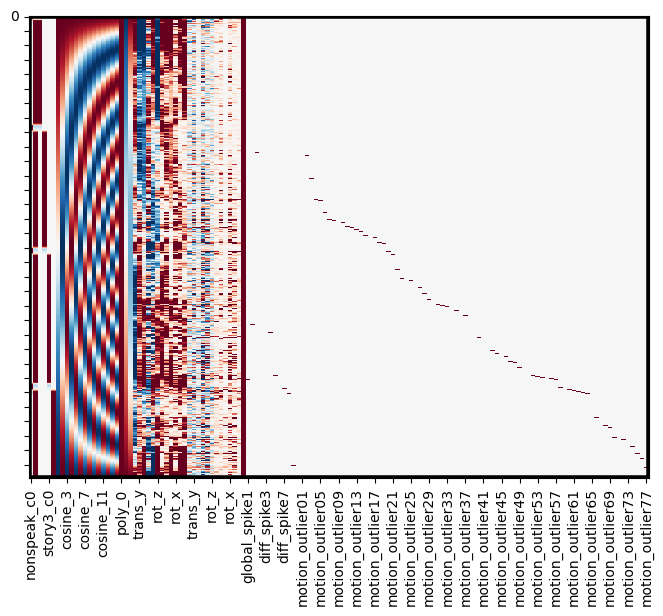

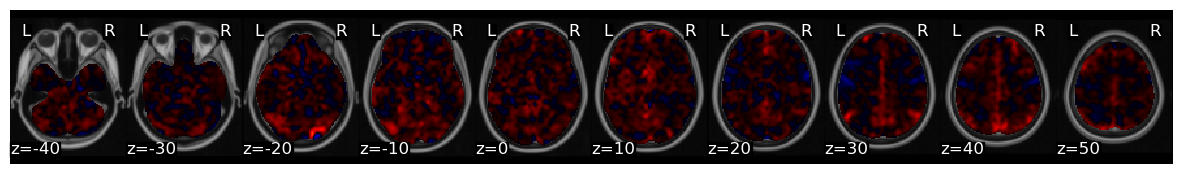

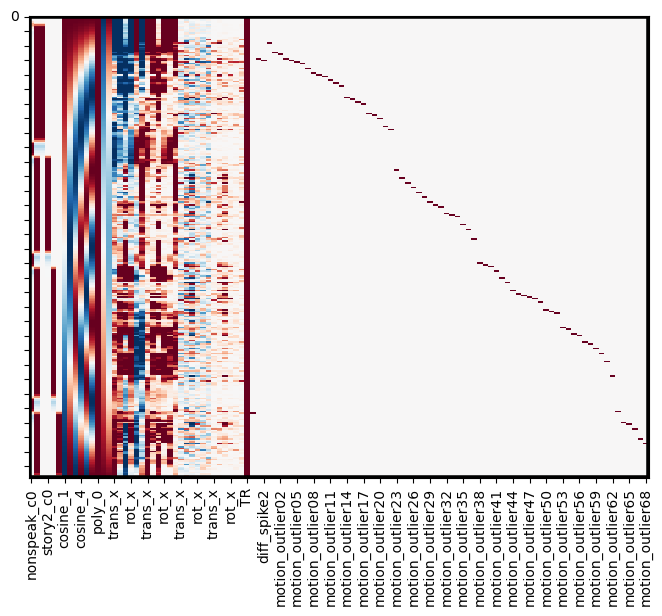

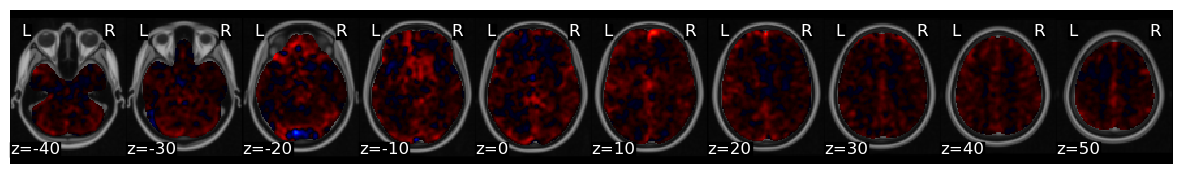

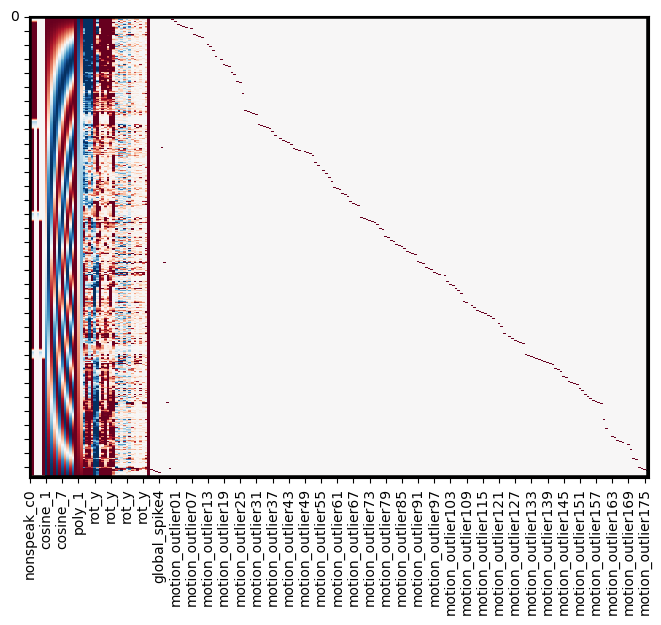

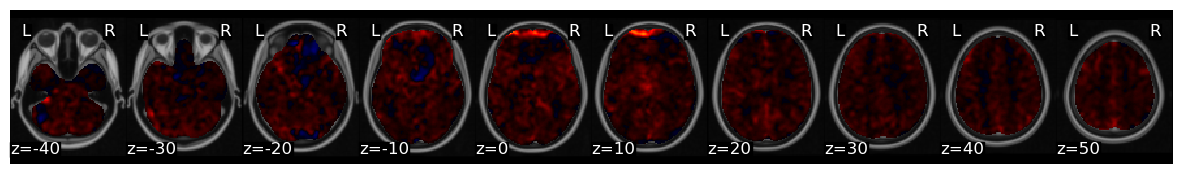

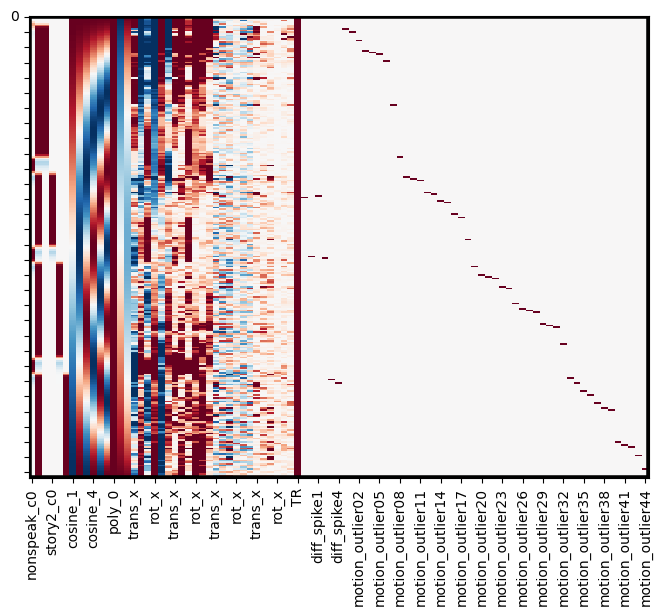

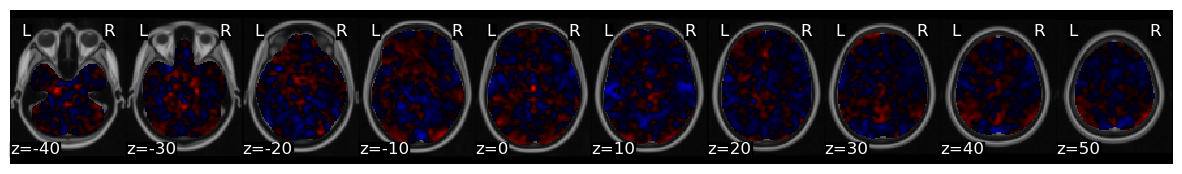

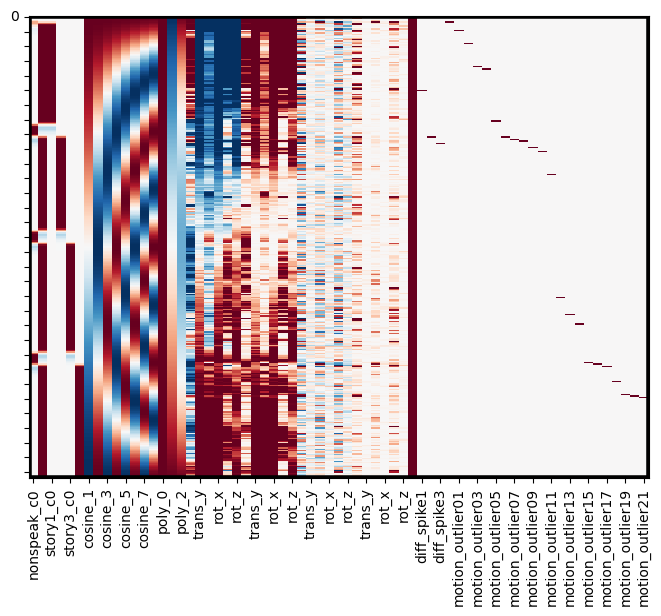

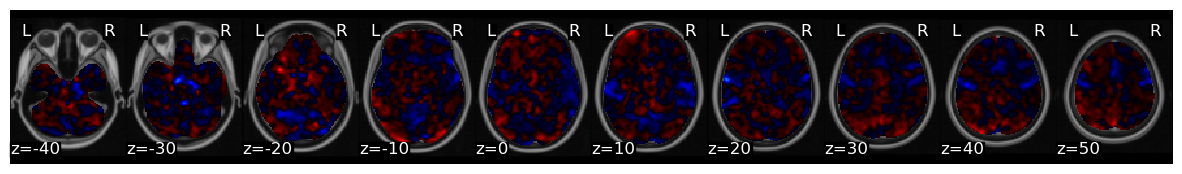

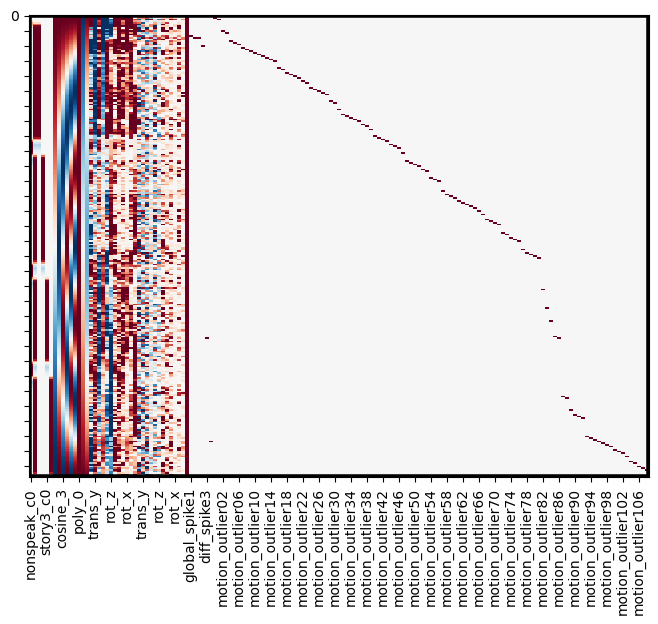

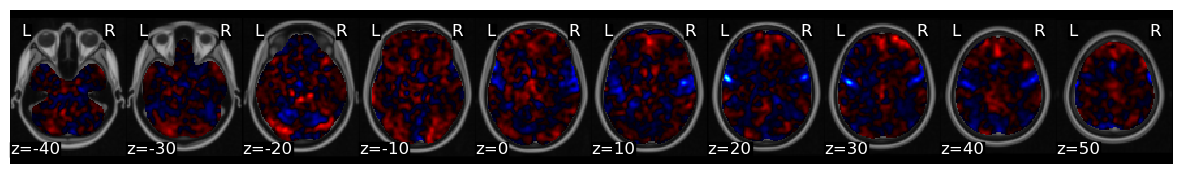

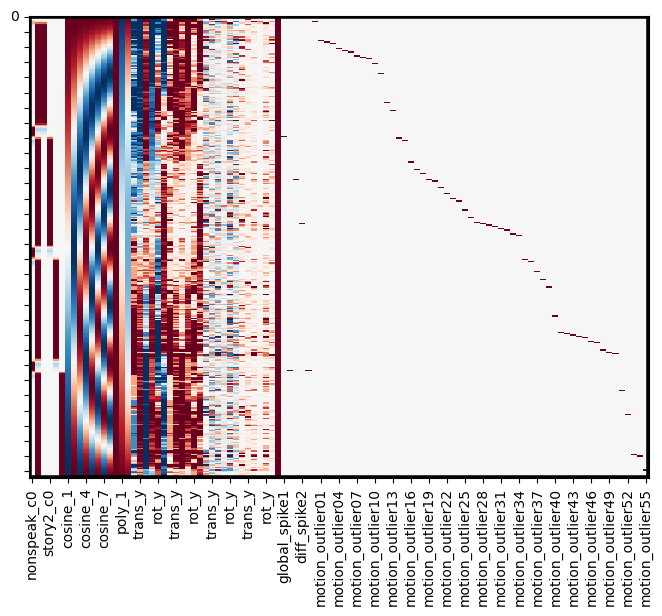

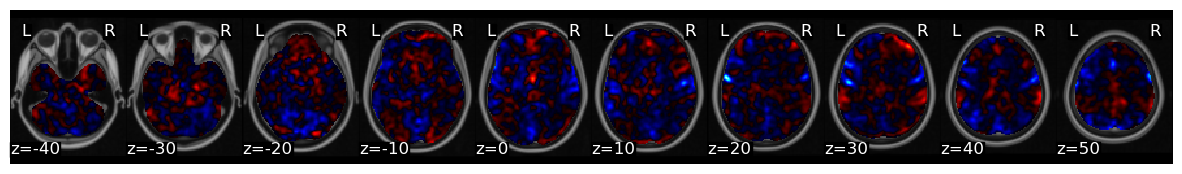

In [136]:
TR = 1.5
outlier_cutoff = 3 # outlier threashold
start = {}
duration = {}
recallfiles = {}
n_trs = {}
for sub in subjects:
    startTime = {}
    durationTime = {}
    recallfile = {}
    n_tr = {}
    for run in np.arange(0,2):
        fileName = glob.glob(os.path.join(Data_dir, 'recalls', f'sub-{sub}_task-recall_countered-*_stimulusCond-0{run+1}*.mat'))[0]
        recallfile[run]  = glob.glob(os.path.join(fmriprep_dir,f'sub-{sub}','func', f'sub-{sub}_task-recall_run-{run+1}_*smoothAROMAnonaggr_bold.nii.gz'))[0]
        n_tr[run] = nib.load(recallfile[run]).shape[3]
        mat = sio.loadmat(fileName)
        startTime[run] = mat['data'][0][0][10] #recall_startTime 
        durationTime[run] = mat['data'][0][0][11]/1.5 #DurationTime
        
        t1 = math.ceil(durationTime[run][0]) #올림해주기
        t2 = math.ceil(durationTime[run][1])
        t3 = math.ceil(durationTime[run][2])
        t4 = math.ceil(durationTime[run][3])
        
        speak_timepoint = [1, 1+t1, 1+t1+10, 1+t1+10+t2, 1+t1+10+t2+10,  1+t1+10+t2+10+t3,  1+t1+10+t2+10+t3+10,  1+t1+10+t2+10+t3+10+t4]
        
        speak = np.zeros(n_tr[run])
        nonspeak = np.zeros(n_tr[run])
        story1 = np.zeros(n_tr[run])
        story2 = np.zeros(n_tr[run])
        story3 = np.zeros(n_tr[run])
        story4 = np.zeros(n_tr[run])
        
        nonspeak[0:1]=1

        speak[speak_timepoint[0]:speak_timepoint[1]] = 1
        story1[speak_timepoint[0]:speak_timepoint[1]] = 1
        nonspeak[speak_timepoint[1]+1:speak_timepoint[2]-1]=1

        speak[speak_timepoint[2]:speak_timepoint[3]] = 1
        story2[speak_timepoint[2]:speak_timepoint[3]] = 1
        nonspeak[speak_timepoint[3]+1:speak_timepoint[4]-1]=1

        speak[speak_timepoint[4]:speak_timepoint[5]] = 1
        story3[speak_timepoint[4]:speak_timepoint[5]] = 1
        nonspeak[speak_timepoint[5]+1:speak_timepoint[6]-1]=1

        speak[speak_timepoint[6]:speak_timepoint[7]] = 1
        story4[speak_timepoint[6]:speak_timepoint[7]] = 1
        nonspeak[speak_timepoint[7]+1:]=1
        
        
        intercept = np.ones(n_tr[run])
        x = (np.vstack([[nonspeak], [speak], [story1], [story2], [story3], [story4]])).T
        dm = Design_Matrix(x, sampling_freq = 1./TR, columns = ['nonspeak','speak', 'story1', 'story2', 'story3', 'story4'])
        dm_conv = dm.convolve()
        dm_conv_filt = dm_conv.add_dct_basis(duration=128)
        dm_conv_filt_poly = dm_conv_filt.add_poly()
        dm_conv_filt_poly = dm_conv_filt_poly.add_poly(order=2, include_lower=True)
        
        data = Brain_Data(recallfile[run])
        spikes = data.find_spikes(global_spike_cutoff=outlier_cutoff, diff_spike_cutoff=outlier_cutoff) # global signal outlier
        covariates = pd.read_csv(glob.glob(os.path.join(fmriprep_dir, f'sub-{sub}', 'func', f'sub-{sub}_task-recall_run-{run+1}_desc-confounds_timeseries.tsv'))[0], sep='\t')
        motionOutliers = covariates.filter(regex='motion_outlier')
        mc = covariates[['trans_x','trans_y','trans_z','rot_x', 'rot_y', 'rot_z']]
        mc_cov = make_motion_covariates(mc, TR) #motion parameter
        dm_conv_filt_poly_cov = pd.concat([dm_conv_filt_poly, mc_cov, spikes, motionOutliers], axis=1)
        dm_conv_filt_poly_cov.heatmap(cmap='RdBu_r', vmin=-1,vmax=1)
        data.X= dm_conv_filt_poly_cov
        stats = data.regress()
        
        cont= stats['beta'][0] - stats['beta'][1]
        stats['beta'][1].write(os.path.join(fmriprep_dir,'betas', f'sub-{sub}_task-recall_run-{run+1}_nonspeak_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz'))
        stats['beta'][0].write(os.path.join(fmriprep_dir,'betas', f'sub-{sub}_task-recall_run-{run+1}_speak_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz'))
        cont.write(os.path.join(fmriprep_dir,'betas', f'sub-{sub}_task-encoding_stimulus_contrast_run-{run+1}_contrask_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz'))
        cont.plot()
        
    start[sub] = startTime
    duration[sub] = durationTime
    recallfiles[sub]=recallfile
    n_trs[sub] = n_tr

In [139]:
#Runlevel anaysis for compare across the conditions 
sub1 = Brain_Data(glob.glob(os.path.join(fmriprep_dir,'betas', 'sub-01_task-encoding_stimulus_contrast_run-*_contrask_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz'))).mean()
sub2 = Brain_Data(glob.glob(os.path.join(fmriprep_dir,'betas', 'sub-02_task-encoding_stimulus_contrast_run-*_contrask_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz'))).mean()
sub3 = Brain_Data(glob.glob(os.path.join(fmriprep_dir,'betas', 'sub-03_task-encoding_stimulus_contrast_run-*_contrask_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz'))).mean()
sub4 = Brain_Data(glob.glob(os.path.join(fmriprep_dir,'betas', 'sub-04_task-encoding_stimulus_contrast_run-*_contrask_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz'))).mean()

sub1.write(os.path.join(fmriprep_dir,'betas', 'sub-01_task-recall_contrast_average_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz'))
sub2.write(os.path.join(fmriprep_dir,'betas', 'sub-02_task-recall_contrast_average_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz'))
sub3.write(os.path.join(fmriprep_dir,'betas', 'sub-03_task-recall_contrast_average_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz'))
sub4.write(os.path.join(fmriprep_dir,'betas', 'sub-04_task-recall_contrast_average_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz'))

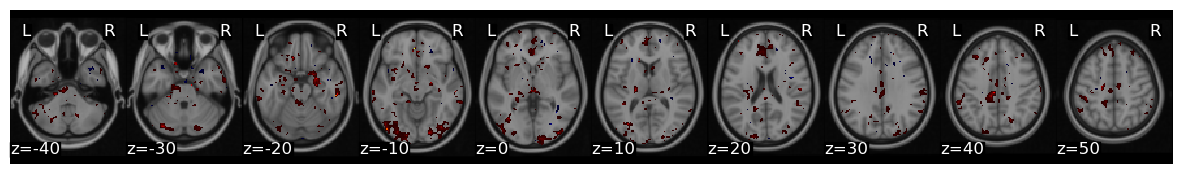

In [142]:
#Group level analysis 
recall_datas = Brain_Data(glob.glob(os.path.join(fmriprep_dir,'betas', 'sub-*_task-recall_contrast_average_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz'))) #speak-nonspeak
recall_stats = recall_datas.ttest(threshold_dict={'unc':.05})
recall_stats['thr_t'].plot()
recall_stats['thr_t'].write(os.path.join(fmriprep_dir,'betas', 'ALLsubjects_task-recall_contrast_average_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz'))

# practice

In [ ]:
n_trs = {}
for sub in subjects:
    recall = {}
    for run in np.arange(0,2):
        mat = sio.loadmat(os.path.join(recall_dir, f'sub-{sub}_task-recall_*_stimulusCond-0{run+1}.mat'))
        recall[run] = mat 
        n_tr[run] = mat['data']
    n_trs[sub] = recall
matfiles

In [176]:
base_dir = '/mnt/c/Users/since/Desktop/KdramaSpring/data/derivatives/'
tr = 1
outlier_cutoff = 3 # outlier threashold
sub = 'sub-03'
task = 'task-recall'
run = 'run-01'

data3= Brain_Data(recall_files[2])
spikes = data3.find_spikes(global_spike_cutoff=outlier_cutoff, diff_spike_cutoff=outlier_cutoff) # global signal outlier
covariates = pd.read_csv(glob.glob(os.path.join(base_dir, sub, 'func', f'*{sub}_{task}_{run}_desc-confounds_timeseries.tsv'))[0], sep='\t')
motionOutliers = covariates.filter(regex='motion_outlier')
mc = covariates[['trans_x','trans_y','trans_z','rot_x', 'rot_y', 'rot_z']]
mc_cov = make_motion_covariates(mc, tr) #motion parameter

In [ ]:
dm_conv_filt_poly_cov3 = pd.concat([dm_conv_filt_poly3, mc_cov, spikes, motionOutliers], axis=1)
dm_conv_filt_poly_cov3.heatmap(cmap='RdBu_r', vmin=-1,vmax=1)

In [ ]:
cont = 

In [31]:
#Run4 3~149/ 155~277/ 283~458/ 464~563
n_trs = [455, 594, 582, 668] 
n_tr = n_trs[2]
speak = np.zeros(n_tr)
nonspeak = np.zeros(n_tr)
story1 = np.zeros(n_tr)
story2 = np.zeros(n_tr)
story3 = np.zeros(n_tr)
story4 = np.zeros(n_tr)

speak[3:149] = 1
story1[3:149] = 1
nonspeak[150:154]=1
speak[155:277] = 1
story2[155:277] = 1
nonspeak[278:282]=1
speak[283:458] = 1
story3[283:458] = 1
nonspeak[459:463]=1
speak[464:563] = 1
story4[464:563] = 1
nonspeak[564:582]=1

In [ ]:
TR = 1.
intercept = np.ones(n_tr)
x = (np.vstack([[nonspeak], [story1], [story2], [story3], [story4]])).T
dm = Design_Matrix(x, sampling_freq = 1./TR, columns = ['nonspeak', 'SecreteForest', 'TwoBoys', 'King', 'YoungSignal'])
dm_conv = dm.convolve()
dm_conv_filt = dm_conv.add_dct_basis(duration=128)
dm_conv_filt_poly = dm_conv_filt.add_poly()
dm_conv_filt_poly = dm_conv_filt_poly.add_poly(order=2, include_lower=True)
dm_conv_filt_poly.heatmap()

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 668 and the array at index 1 has size 1

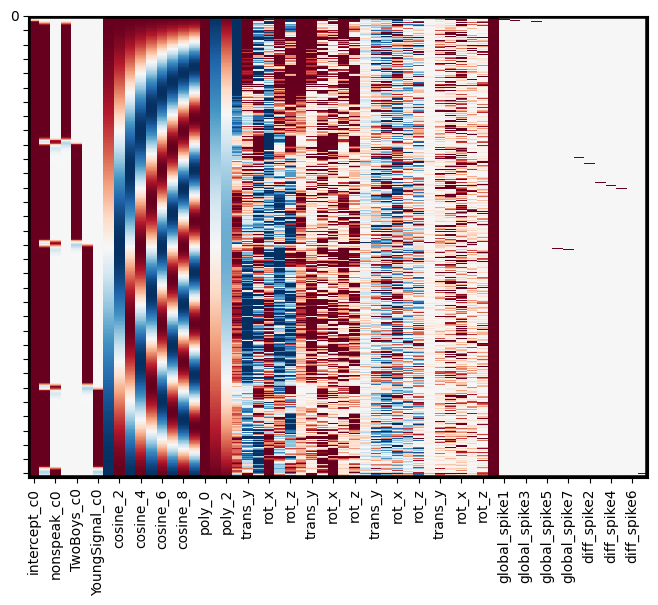

In [177]:
dm_conv_filt_poly_cov3 = pd.concat([dm_conv_filt_poly3, mc_cov, spikes, motionOutliers], axis=1)
dm_conv_filt_poly_cov3.heatmap(cmap='RdBu_r', vmin=-1,vmax=1)

In [178]:
data3.X= dm_conv_filt_poly_cov3
stats3 = data3.regress()

In [196]:
stats3['beta'][1].write(f'{sub}_run-6_speak_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz')
stats3['beta'][2].write(f'{sub}_run-6_nonspeak_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz')

In [144]:
#Run4 - 3~111/ 117~329 / 334~514 / 519~675
n_trs = [455, 594, 582, 668] 
n_tr = n_trs[3]
speak = np.zeros(n_tr)
nonspeak = np.zeros(n_tr)

story1 = np.zeros(n_tr)
story2 = np.zeros(n_tr)
story3 = np.zeros(n_tr)
story4 = np.zeros(n_tr)

speak[3:111] = 1
story1[3:111] = 1
nonspeak[112:116]=1
speak[117:329] = 1
story2[117:329] = 1
nonspeak[330:333]=1
speak[334:514] = 1
story3[334:514] = 1
nonspeak[515:518]=1
speak[519:675] = 1
story4[519:675] = 1
nonspeak[676:668]=1
speak

array([0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [184]:
from nltools.data import Brain_Data, Design_Matrix
TR = 1
intercept = np.ones(n_tr)
x4 = (np.vstack([[intercept], [speak], [nonspeak], [story1], [story2], [story3], [story4]])).T
print(x4.shape)
dm4 = Design_Matrix(x4, sampling_freq = 1./TR, columns = ['intercept','speak', 'nonspeak', 'SecreteForest', 'TwoBoys', 'King', 'YoungSignal'])

(668, 7)


In [185]:
dm_conv4 = dm4.convolve()
dm_conv_filt4 = dm_conv4.add_dct_basis(duration=128)
dm_conv_filt_poly4 = dm_conv_filt4.add_poly(order=2, include_lower=True)

In [186]:
base_dir = '/mnt/c/Users/since/Desktop/Kdrama/data/derivatives/'
tr = 1
outlier_cutoff = 3 # outlier threashold
sub = 'sub-03'
task = 'task-recall'
run = 'run-4'

data4= Brain_Data(recall_files[3])
spikes = data4.find_spikes(global_spike_cutoff=outlier_cutoff, diff_spike_cutoff=outlier_cutoff) # global signal outlier
covariates = pd.read_csv(glob.glob(os.path.join(base_dir, sub, 'func', f'*{sub}_{task}_{run}_desc-confounds_timeseries.tsv'))[0], sep='\t')
motionOutliers = covariates.filter(regex='motion_outlier')
mc = covariates[['trans_x','trans_y','trans_z','rot_x', 'rot_y', 'rot_z']]
mc_cov = make_motion_covariates(mc, tr) #motion parameter

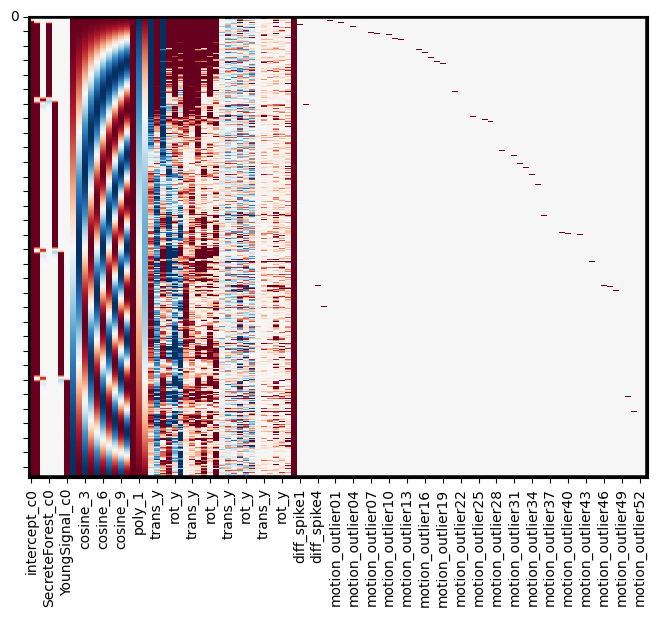

In [187]:
dm_conv_filt_poly_cov4 = pd.concat([dm_conv_filt_poly4, mc_cov, spikes, motionOutliers], axis=1)
dm_conv_filt_poly_cov4.heatmap(cmap='RdBu_r', vmin=-1,vmax=1)

In [188]:
data4.X= dm_conv_filt_poly_cov4
stats4 = data4.regress()

In [197]:
stats4['beta'][1].write(f'{sub}_run-8_speak_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz')
stats4['beta'][2].write(f'{sub}_run-8_nonspeak_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz')

single sub GLM

In [207]:
import glob

data_dir = '/mnt/c/Users/since/Desktop/'
con1_file_list = glob.glob(os.path.join(data_dir, 'sub-03_*_speak_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz'))
con2_file_list = glob.glob(os.path.join(data_dir, 'sub-03_*_nonspeak_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz'))
con1_file_list
con1_dat = Brain_Data(con1_file_list)
con2_dat = Brain_Data(con2_file_list)

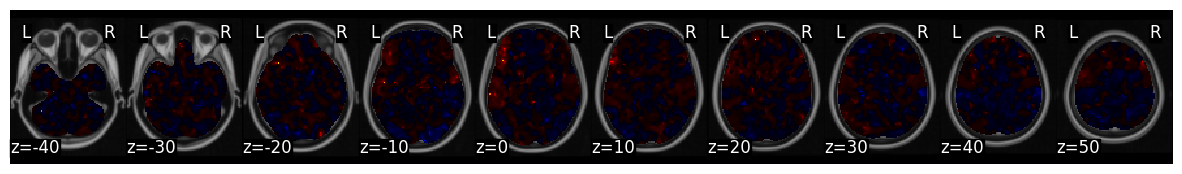

In [211]:
con1_stats = con1_dat.ttest(threshold_dict={'fdr':.05})
con1_stats['t'].plot()

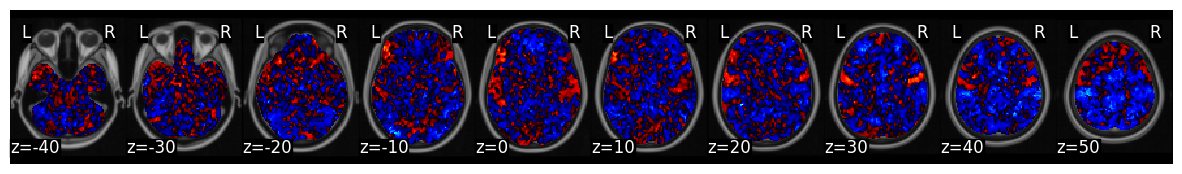

In [226]:
con2_stats = con2_dat.ttest()
con2_stats['t'].plot()
con2_stats['t'].write(f'GLM_for_non_speak_fMRI_bold.nii.gz')

In [231]:
con1_v_con2 = con2_dat-con1_dat

#con1_v_con2_stats = con1_v_con2.ttest(threshold_dict={'fdr':.05})
con1_v_con2_stats = con1_v_con2.ttest(threshold_dict={'unc':.001})
#con1_v_con2_stats['t'].plot()
#con1_v_con2_stats['thr_t'].plot()
con1_v_con2_stats['thr_t'].write(f'GLM_for_contras_nonSpeak-Speak_unc001_fMRI_bold.nii.gz')
#con1_v_con2_stats['t'].write(f'GLM_for_contras_nonSpeak-Speak_fMRI_bold.nii.gz')

In [ ]:
sub = '03'
recall_files = glob.glob(os.path.join(fmriprep_dir,f'sub-{sub}','func', '*recall*smoothAROMAnonaggr_bold.nii.gz'))
n_trs = [455, 594, 582, 668] 


# Total subject analysis

- 참가자들 Recall timeline

In [28]:
#load images 

sub_03 = [[0, 73, 86, 194, 208, 333, 340, 445], [2, 130, 135, 301, 307, 463, 469, 574], [3, 149, 155, 277, 283, 458, 464, 563], [3, 111, 117, 329, 334, 514, 519, 675]]
sub_04 = [[0, 274, 283, 459, 466, 713, 720, 902], [2, 168, 176, 305, 311, 520, 527, 710], [3, 271, 277, 487, 494, 665, 672, 813],  [1, 234, 243, 509, 515, 713, 722, 917]]
sub_05 = [[5, 68, 86, 141, 147, 232, 238, 320], [3, 170, 177, 355, 362, 552, 558, 760], [2, 185, 183, 318, 324, 474, 482, 597], [2, 215, 222, 471, 477, 737, 744, 940]]
sub_07 = [[0, 54, 62, 130, 140, 206, 210, 262], [0, 116, 141, 300, 306, 445, 450, 610], [0, 150, 156, 268, 274, 386, 392, 472], [0, 123, 126, 277, 284, 430, 438, 550]]

recall = [sub_03, sub_04, sub_05, sub_07]
Range = {}
recall_files = {}
func_imgs = {}
n_trs = {} 
for i, sub in enumerate(['07']):
    print(i, sub)
    # Range[sub] = recall[i]
    if sub == '07':
        recall_files[sub] = glob.glob(os.path.join(fmriprep_dir,f'sub-{sub}','func', '*recall*MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'))
    else: 
        recall_files[sub] = glob.glob(os.path.join(fmriprep_dir,f'sub-{sub}','func', '*recall*smoothAROMAnonaggr_bold.nii.gz'))
        
    sub_func_imgs = {}
    sub_n_trs = []
    for run in np.arange(0,4):
        sub_func_imgs[run] = nib.load(recall_files[sub][run]) 
        size = sub_func_imgs[run].shape[3]
        # print(size)
        sub_n_trs.append(size)
    func_imgs[sub] = sub_func_imgs
    n_trs[sub] = sub_n_trs
print(func_imgs)
print(n_trs)
Range['07'] = recall[3]
Range

0 07
{'07': {0: <nibabel.nifti1.Nifti1Image object at 0x7ffa8b27bb90>, 1: <nibabel.nifti1.Nifti1Image object at 0x7ffa7fd06e50>, 2: <nibabel.nifti1.Nifti1Image object at 0x7ffa7fcfd1d0>, 3: <nibabel.nifti1.Nifti1Image object at 0x7ffa8929b950>}}
{'07': [294, 625, 494, 565]}


{'07': [[0, 54, 62, 130, 140, 206, 210, 262],
  [0, 116, 141, 300, 306, 445, 450, 610],
  [0, 150, 156, 268, 274, 386, 392, 472],
  [0, 123, 126, 277, 284, 430, 438, 550]]}

In [29]:
# extracts events timepoints
import numpy as np
#for i, sub in enumerate(['03', '04', '05']): 
    # Make EventCode
    
sub = '07'
speaks = {}
#sub_speaks = []
nonspeaks = {}
story1 = {}
story2 = {}
story3 = {}
story4 = {}
for run in range(4): 
    n_tr = n_trs[sub][run]
    timepoints = Range[sub][run] 
    #speak = np.zeros(n_tr)
    nonspeak = np.zeros(n_tr)
    story = np.zeros(n_tr)
    speak = np.zeros(n_tr)
    print('2.story.shape', story.shape)
    storys = {}
    for i in range(4):
        a = timepoints[2*i]
        b = timepoints[2*i+1]
        print(a,b)
        
        story[a:b] = 1
        speak[a:b] = 1
        if i == 3:
            nonspeak[b+1:n_tr]= 1
        else:
            nonspeak[b+1:timepoints[2*(i+1)]-1]= 1
        storys[i]=story
    speaks[run] = speak
    nonspeaks[run] = nonspeak
    story1[run] = storys[0]
    story2[run] = storys[1]
    story3[run] = storys[2]
    story4[run] = storys[3]
#speak

2.story.shape (294,)
0 54
62 130
140 206
210 262
2.story.shape (625,)
0 116
141 300
306 445
450 610
2.story.shape (494,)
0 150
156 268
274 386
392 472
2.story.shape (565,)
0 123
126 277
284 430
438 550


In [30]:
cd /mnt/c/Users/since/Desktop/glm

/mnt/c/Users/since/Desktop/glm


Design Matrix already has 0th order polynomial...skipping
finish making sub-07_run-1 DM
finish mc_covs
finish making run-1 CM
finish concatenating run-1 DM
finish fitting
Design Matrix already has 0th order polynomial...skipping
finish making sub-07_run-2 DM
finish mc_covs
finish making run-2 CM
finish concatenating run-2 DM
finish fitting
Design Matrix already has 0th order polynomial...skipping
finish making sub-07_run-3 DM
finish mc_covs
finish making run-3 CM
finish concatenating run-3 DM
finish fitting
Design Matrix already has 0th order polynomial...skipping
finish making sub-07_run-4 DM
finish mc_covs
finish making run-4 CM
finish concatenating run-4 DM
finish fitting


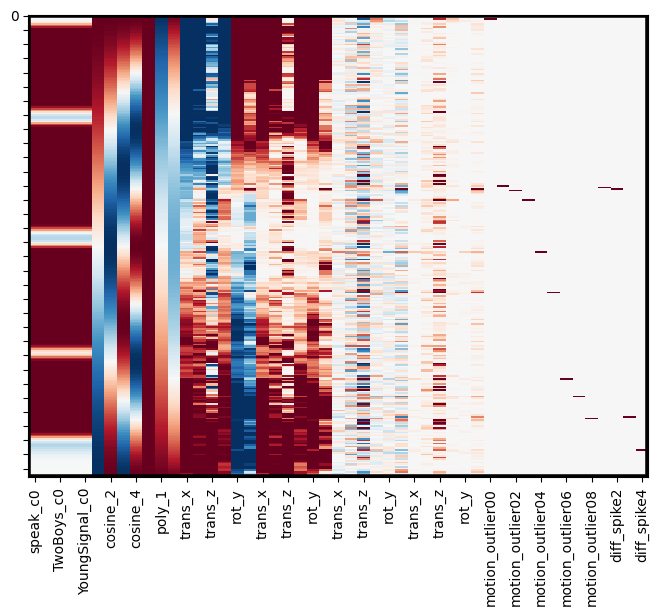

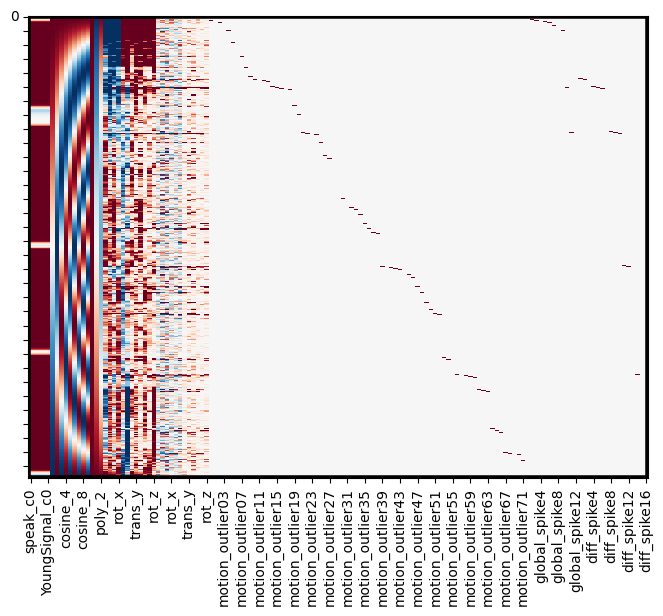

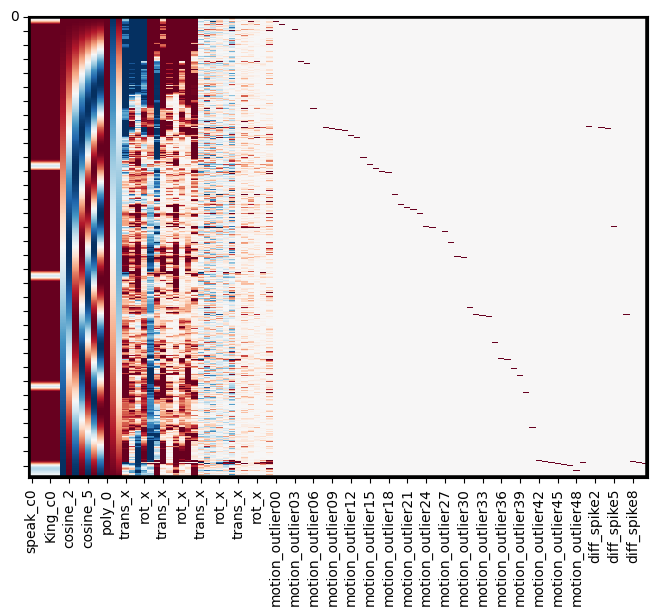

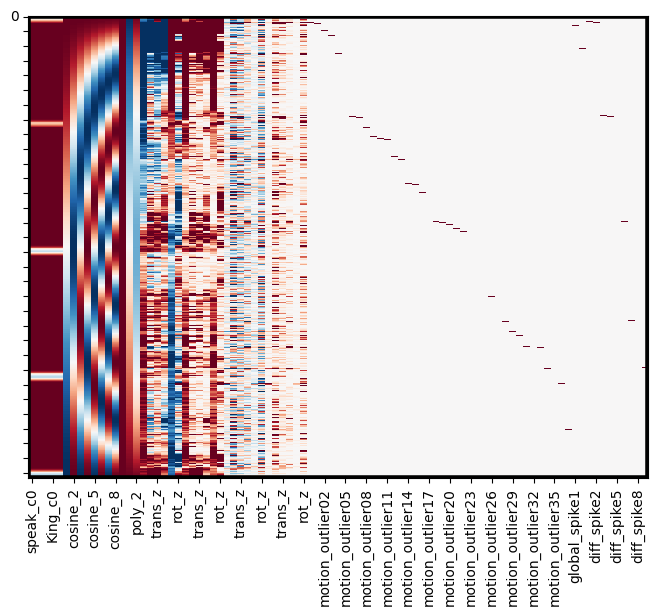

In [31]:
from nltools.data import Brain_Data, Design_Matrix
from nilearn.image import concat_imgs, mean_img

base_dir = '/mnt/c/Users/since/Desktop/Kdrama/data/derivatives/'
tr = 1
outlier_cutoff = 3 # outlier threashold
for run in range(4):
    # 실험 변수 
    n_tr =  n_trs[sub][run]
    x = (np.vstack([[speaks[run]], [story1[run]], [story2[run]], [story3[run]], [story4[run]]])).T     
    dm = Design_Matrix(x, sampling_freq = 1./tr, columns = ['speak', 'SecreteForest', 'TwoBoys', 'King', 'YoungSignal'])
    dm_conv = dm.convolve()
    dm_conv_filt = dm_conv.add_dct_basis(duration=128)
    dm_conv_filt_poly = dm_conv_filt.add_poly() # intercept 
    dm_conv_filt_poly = dm_conv_filt_poly.add_poly(order=2, include_lower=True)
    print(f'finish making sub-{sub}_run-{run+1} DM')
    
    # 외생 변수 집어넣기 
    data = Brain_Data(recall_files[sub][run]) #nltools -> nilearn 으로 바꿔서 해보면 from nilearn import image >> print(image.load_img(path)
    spikes = data.find_spikes(global_spike_cutoff=outlier_cutoff, diff_spike_cutoff=outlier_cutoff) # global signal outlier
    spikes.drop(['TR'], axis =1, inplace = True)
    covariates = pd.read_csv(glob.glob(os.path.join(base_dir,  f'sub-{sub}', 'func', f'sub-{sub}_task-recall_run-{run+1}_desc-confounds_timeseries.tsv'))[0], sep='\t')
    motionOutliers = covariates.filter(regex='motion_outlier')
    mc = covariates[['trans_x','trans_y','trans_z','rot_x', 'rot_y', 'rot_z']]
    mc_cov = make_motion_covariates(mc, tr) #motion parameter
    print('finish mc_covs')
    print(f'finish making run-{run+1} CM')
    # 외생 변수와 실험변수 합치기 
    dm_conv_filt_poly_cov = pd.concat([dm_conv_filt_poly, mc_cov, motionOutliers,spikes ], axis=1)
    dm_conv_filt_poly_cov.heatmap(cmap='RdBu_r', vmin=-1,vmax=1)    
    print(f'finish concatenating run-{run+1} DM')
    
    # 데이터에 적합시키기/ 
    data.X= dm_conv_filt_poly_cov
    stats = data.regress()
    print('finish fitting')
    #betas[run] = stats['beta']
    stats['beta'][0].write(f'sub-{sub}_run-{run+1}_speak_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz') # speak
    #stats['beta'].write(f'sub-{sub}_run-{run+1}_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz') #nonSpeak

## Run-level analysis: The summary statistics approach

In [32]:
#load data 
data_dir = '/mnt/c/Users/since/Desktop/glm/'
beta_files = {}
for sub in ['07']:
    beta_files[sub] = glob.glob(os.path.join(data_dir,f'sub-{sub}_run-*_speak_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz'))
    print(beta_files[sub])

['/mnt/c/Users/since/Desktop/glm/sub-07_run-1_speak_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz', '/mnt/c/Users/since/Desktop/glm/sub-07_run-2_speak_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz', '/mnt/c/Users/since/Desktop/glm/sub-07_run-3_speak_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz', '/mnt/c/Users/since/Desktop/glm/sub-07_run-4_speak_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz']


In [33]:
cd '/mnt/c/Users/since/Desktop/glm/results'

/mnt/c/Users/since/Desktop/glm/results


In [34]:
beta_files[sub]

['/mnt/c/Users/since/Desktop/glm/sub-07_run-1_speak_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz',
 '/mnt/c/Users/since/Desktop/glm/sub-07_run-2_speak_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz',
 '/mnt/c/Users/since/Desktop/glm/sub-07_run-3_speak_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz',
 '/mnt/c/Users/since/Desktop/glm/sub-07_run-4_speak_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz']

/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/nilearn/masking.py:858: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


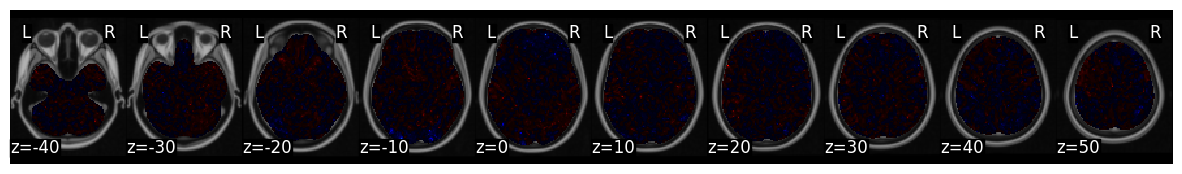

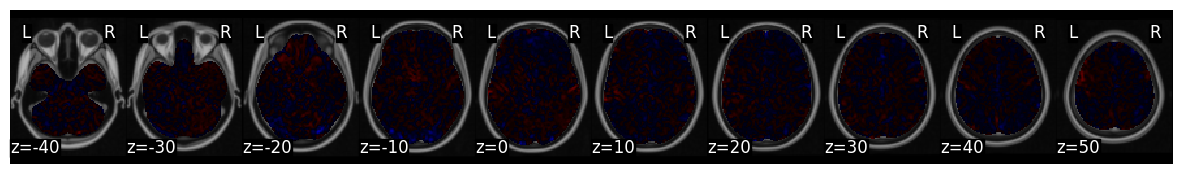

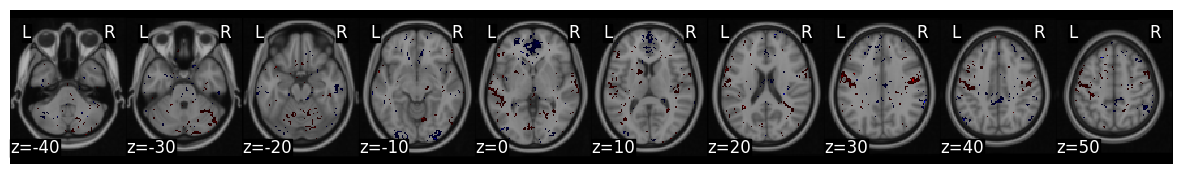

In [35]:
#sub = '03' 
#running contrast for one-sample ttest 
img = Brain_Data(beta_files[sub])
img_stats = img.ttest()
img_stats['t'].plot()
#img_stats['t'].write(f'sub-{sub}_speak_ttest_4_runs_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz') # speak

#mean
#img.mean().plot()

# Run-level analysis 
x_rl = pd.DataFrame({'Intercept': np.ones(4)}) #make run-wise DM
img.X =  x_rl
stats[sub] = img.regress() #inv(X_rl.T @ X_rl)@ X_rl.T@y_rl
stats[sub]['beta'].plot()
stats[sub]['beta'].write(f'sub-{sub}_averaged_speak_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz')


sub_files = glob.glob(os.path.join(data_dir, 'results', 'sub-*_averaged_speak_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz'))
imgs = Brain_Data(sub_files)
img_statss = imgs.ttest(threshold_dict={'unc':.05})
img_statss['thr_t'].plot()
#img_statss['t'].write(f'All_subs_speak_ttest_4_runs_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz')

# One Sample t-test

In [241]:
import glob

data_dir = '/mnt/c/Users/since/Desktop/glm'
con1_file_list = glob.glob(os.path.join(data_dir, 'sub-*_speak_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz'))
con2_file_list = glob.glob(os.path.join(data_dir, 'sub-*_nonspeak_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz'))
con1_file_list
con1_dat = Brain_Data(con1_file_list)
con2_dat = Brain_Data(con2_file_list)

In [245]:
con1_file_list.sort()
con2_file_list.sort()

contrasts = []
for sub in ['03', '04', '05']:
    for run in range(4):
        con1 = glob.glob(os.path.join(data_dir, f'sub-{sub}_run-{run}_speak_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz'))
        con2 = glob.glob(os.path.join(data_dir, f'sub-{sub}_run-{run}_nonspeak_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz'))
        con1_dat = Brain_Data(con1)
        con2_dat = Brain_Data(con2)
        contrast = con2_dat-con1_dat

        contrast.write(f'sub-{sub}_run-{run}_contrast_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz') #nonSpeak

In [238]:
sub03_con1 = con1_dat[0:3].mean()
sub03_con1.write(f'sub-{sub}_run-{run}_nonspeak_betas_denoised_AROMA_preprocessed_fMRI_bold.nii.gz') #nonSpeak
#on1_stats['t'].plot()

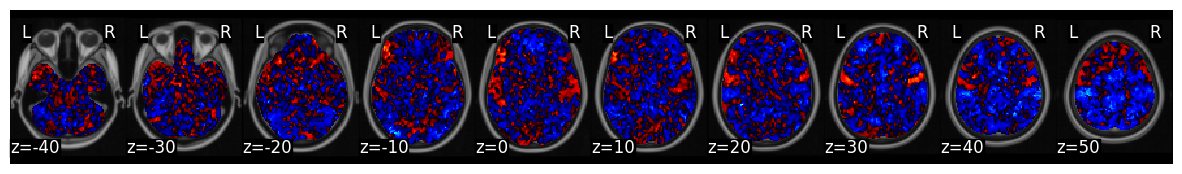

In [217]:
con2_stats = con2_dat.ttest(threshold_dict={'unc':.001})
con2_stats['t'].plot()

/home/sincerely/.conda/envs/fmri01/lib/python3.7/site-packages/nilearn/masking.py:858: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


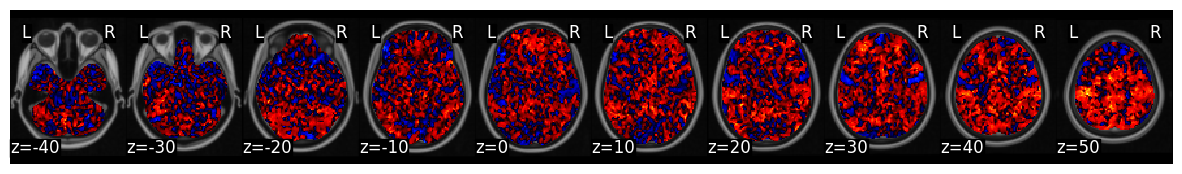

In [219]:
con1_v_con2 = con1_dat-con2_dat

con1_v_con2_stats = con1_v_con2.ttest(threshold_dict={'unc':.001})
con1_v_con2_stats['t'].plot()